In [1]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from pathlib import Path

# from torch.utils.data import Dataset

from pathlib import Path
import os

# from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import numpy as np

import random

import tensorflow as tf
import datetime, os

print_config()

2024-04-02 00:01:30.950744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 00:01:31.714793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/Documents/RISA/3D_segmentation/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

Fo

In [2]:
import os
root_dir = Path("/home/pawel/Documents/RISA/3D_segmentation/logger")
print(root_dir)

/home/pawel/Documents/RISA/3D_segmentation/logger


In [3]:
class CTDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image_file = np.load(str(image_filepath))

        path_elements = list(Path(image_filepath).parts)
        index = path_elements.index('scans')
        path_elements[index] = 'airways'

        mask_filepath = os.path.join(*path_elements)
        mask_file = np.load(str(mask_filepath))

        if self.transform is not None:
            transformed_images = []
            transformed_masks = []
            for i in range(0, image_file.shape[-1]):
                
                image_slice = image_file[..., i]
                mask_slice = mask_file[..., i]

                transformed = self.transform(image=image_slice, mask=mask_slice)

                transformed_images.append(transformed["image"])
                transformed_masks.append(transformed["mask"])

            image_file = torch.stack(transformed_images, dim=0)
            mask_file = torch.stack(transformed_masks, dim=0).type(torch.float16)
            mask_file = mask_file.unsqueeze(0)

            image_file = image_file.permute(1, 0, 2, 3)

        return image_file, mask_file

In [4]:
class CTDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        A.Rotate(limit=15, p=1.0),
        # A.Resize(height=64, width=64),
        A.RandomCrop(height=160, width=160),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2()
        ])
        self.transforms = A.Compose([
        A.ToFloat(max_value=1024+400, always_apply=True),
        # A.Resize(height=64, width=64),
        A.RandomCrop(height=160, width=160),
        # A.Normalize(mean=[-1024/400], std=[1/400], always_apply=True),
        ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        self.path_to_file = '/home/pawel/Documents/RISA/3D_segmentation/dataset'


    def prepare_data(self):
        if os.path.exists(self.path_to_file):
            print("Path exists")
            images_paths = sorted(Path(self.path_to_file).rglob('*.npy'))
            for image_path in images_paths:
                image = np.load(str(image_path))

                if image is None:
                    print("Unlink image: ", image_path)
                    image_path.unlink()
        else:
            print("Path does not exist")


    def setup(self, stage):
        paths = sorted(Path(os.path.join(self.path_to_file, 'scans')).glob('*.npy'))

        self.train_paths, self.val_paths = train_test_split(paths, test_size=0.3, random_state=42)

        self.train_ds = CTDataset(self.train_paths, transform=self.augmentations)
        self.val_ds = CTDataset(self.val_paths, transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds,
                            batch_size=10,
                            shuffle=True,
                            num_workers=6,
                            collate_fn=list_data_collate
                        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=6, num_workers=6)

## Visualization

Path exists
image shape: torch.Size([64, 160, 160]), label shape: torch.Size([64, 160, 160])


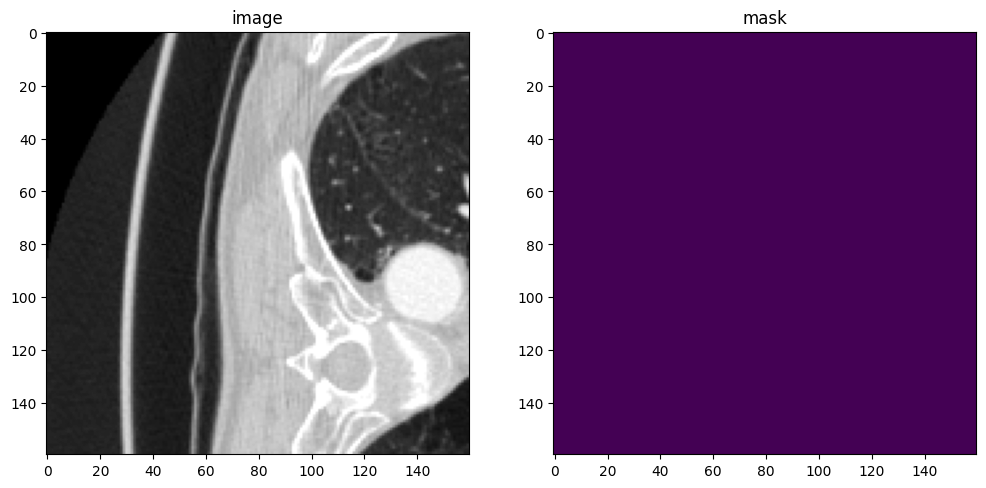

In [5]:
dataModule = CTDataModule()
dataModule.prepare_data()
dataModule.setup('fit')
val_dataset = dataModule.val_ds

object_number = random.randint(0, len(val_dataset)-1)

image, mask = val_dataset.__getitem__(object_number)
image = image.squeeze(0)
mask = mask.squeeze(0)

slice_number = random.randint(0, image.shape[0]-1)

print(f"image shape: {image.shape}, label shape: {mask.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[slice_number, :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("mask")
plt.imshow(mask[slice_number, :, :])
plt.show()

In [6]:
from x_unet import XUnet

class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2, 2),
            num_res_units=3,
            norm=Norm.BATCH,
        )

        # self._model = XUnet(
        #     dim = 8,
        #     frame_kernel_size = 5,                 # set this to greater than 1
        #     channels = 1,
        #     dim_mults = (1, 2, 4, 8),
        #     nested_unet_depths = (5, 4, 2, 1),     # nested unet depths, from unet-squared paper
        #     consolidate_upsample_fmaps = True,     # whether to consolidate outputs from all upsample blocks, used in unet-squared paper
        #     weight_standardize = True
        # )

        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_loss = 0
        self.best_val_epoch_dice = 0
        self.best_val_epoch_loss = 0
        self.validation_step_outputs = []

    def forward(self, x):
        return self._model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # print(images.shape)
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        self.log('train_loss', loss, prog_bar=True)
        # self.accuracy.update(output, labels)
        # self.log('train_acc', self.accuracy, prog_bar=True)
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        roi_size = (32, 128, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)
        self.log('val_loss', loss, prog_bar=True)
        return d

    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch_dice = self.current_epoch

        if mean_val_loss < self.best_val_loss:
            self.best_val_loss = mean_val_loss
            self.best_val_epoch_loss = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch_dice}"
            f"\ncurrent mean loss: {mean_val_loss:.4f}"
            f"\nbest mean loss: {self.best_val_loss:.4f}"
            f"at epoch: {self.best_val_epoch_loss}"
        )
        self.validation_step_outputs.clear()  # free memory
        return {"log": tensorboard_logs}

In [7]:
# set up loggers and checkpoints
print(root_dir)
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

/home/pawel/Documents/RISA/3D_segmentation/logger


In [8]:
# initialise the LightningModule
net = Net()

checkpoint_path = '/home/pawel/Documents/RISA/3D_segmentation/model_segmentation/checkpoints/epoch_319-0.42079.ckpt'
# net = Net.load_from_checkpoint(checkpoint_path)

data_module = CTDataModule()

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=600,
    callbacks= pytorch_lightning.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, save_last=False, verbose=True, dirpath='/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints', filename='epoch_{epoch}-{val_loss:.5f}',  auto_insert_metric_name=False),
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=2,
)

# train
trainer.fit(net, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Path exists


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 28.7 M
1 | loss_function | DiceLoss | 0     
-------------------------------------------
28.7 M    Trainable params
0         Non-trainable params
28.7 M    Total params
114.906   Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.92it/s]current epoch: 0 current mean dice: 0.0148
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1101best mean loss: 0.0000at epoch: 0
Epoch 0: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.665]current epoch: 0 current mean dice: 0.0093
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1226best mean loss: 0.0000at epoch: 0
Epoch 0: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.665, val_loss=0.666]

Epoch 0, global step 9: 'val_loss' reached 0.66566 (best 0.66566), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_0-0.66566.ckpt' as top 1


Epoch 1: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.656, val_loss=0.666]current epoch: 1 current mean dice: 0.0097
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1208best mean loss: 0.0000at epoch: 0
Epoch 1: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.656, val_loss=0.656]

Epoch 1, global step 18: 'val_loss' reached 0.65564 (best 0.65564), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_1-0.65564.ckpt' as top 1


Epoch 2: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.648, val_loss=0.656]current epoch: 2 current mean dice: 0.0097
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1189best mean loss: 0.0000at epoch: 0
Epoch 2: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.648, val_loss=0.645]

Epoch 2, global step 27: 'val_loss' reached 0.64538 (best 0.64538), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_2-0.64538.ckpt' as top 1


Epoch 3: 100%|██████████| 9/9 [00:09<00:00,  0.93it/s, v_num=7, train_loss=0.643, val_loss=0.645]current epoch: 3 current mean dice: 0.0094
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1183best mean loss: 0.0000at epoch: 0
Epoch 3: 100%|██████████| 9/9 [00:16<00:00,  0.53it/s, v_num=7, train_loss=0.643, val_loss=0.642]

Epoch 3, global step 36: 'val_loss' reached 0.64217 (best 0.64217), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_3-0.64217.ckpt' as top 1


Epoch 4: 100%|██████████| 9/9 [00:11<00:00,  0.78it/s, v_num=7, train_loss=0.642, val_loss=0.642]current epoch: 4 current mean dice: 0.0099
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1177best mean loss: 0.0000at epoch: 0
Epoch 4: 100%|██████████| 9/9 [00:19<00:00,  0.47it/s, v_num=7, train_loss=0.642, val_loss=0.639]

Epoch 4, global step 45: 'val_loss' reached 0.63897 (best 0.63897), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_4-0.63897.ckpt' as top 1


Epoch 5: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.636, val_loss=0.639]current epoch: 5 current mean dice: 0.0099
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1174best mean loss: 0.0000at epoch: 0
Epoch 5: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.636, val_loss=0.637]

Epoch 5, global step 54: 'val_loss' reached 0.63741 (best 0.63741), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_5-0.63741.ckpt' as top 1


Epoch 6: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.633, val_loss=0.637]current epoch: 6 current mean dice: 0.0101
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1167best mean loss: 0.0000at epoch: 0
Epoch 6: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.633, val_loss=0.633]

Epoch 6, global step 63: 'val_loss' reached 0.63294 (best 0.63294), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_6-0.63294.ckpt' as top 1


Epoch 7: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.631, val_loss=0.633]current epoch: 7 current mean dice: 0.0100
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1162best mean loss: 0.0000at epoch: 0
Epoch 7: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.631, val_loss=0.631]

Epoch 7, global step 72: 'val_loss' reached 0.63084 (best 0.63084), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_7-0.63084.ckpt' as top 1


Epoch 8: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.627, val_loss=0.631]current epoch: 8 current mean dice: 0.0100
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1160best mean loss: 0.0000at epoch: 0
Epoch 8: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.627, val_loss=0.630]

Epoch 8, global step 81: 'val_loss' reached 0.62951 (best 0.62951), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_8-0.62951.ckpt' as top 1


Epoch 9: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.624, val_loss=0.630]current epoch: 9 current mean dice: 0.0091
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1155best mean loss: 0.0000at epoch: 0
Epoch 9: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.624, val_loss=0.627]

Epoch 9, global step 90: 'val_loss' reached 0.62670 (best 0.62670), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_9-0.62670.ckpt' as top 1


Epoch 10: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.619, val_loss=0.627]current epoch: 10 current mean dice: 0.0099
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1146best mean loss: 0.0000at epoch: 0
Epoch 10: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.619, val_loss=0.622]

Epoch 10, global step 99: 'val_loss' reached 0.62183 (best 0.62183), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_10-0.62183.ckpt' as top 1


Epoch 11: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.616, val_loss=0.622]current epoch: 11 current mean dice: 0.0096
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1139best mean loss: 0.0000at epoch: 0
Epoch 11: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.616, val_loss=0.618]

Epoch 11, global step 108: 'val_loss' reached 0.61829 (best 0.61829), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_11-0.61829.ckpt' as top 1


Epoch 12: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.614, val_loss=0.618]current epoch: 12 current mean dice: 0.0092
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1135best mean loss: 0.0000at epoch: 0
Epoch 12: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.614, val_loss=0.616]

Epoch 12, global step 117: 'val_loss' reached 0.61601 (best 0.61601), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_12-0.61601.ckpt' as top 1


Epoch 13: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.610, val_loss=0.616]current epoch: 13 current mean dice: 0.0095
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1126best mean loss: 0.0000at epoch: 0
Epoch 13: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.610, val_loss=0.612]

Epoch 13, global step 126: 'val_loss' reached 0.61178 (best 0.61178), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_13-0.61178.ckpt' as top 1


Epoch 14: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.610, val_loss=0.612]current epoch: 14 current mean dice: 0.0093
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1124best mean loss: 0.0000at epoch: 0
Epoch 14: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.610, val_loss=0.610]

Epoch 14, global step 135: 'val_loss' reached 0.60971 (best 0.60971), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_14-0.60971.ckpt' as top 1


Epoch 15: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.605, val_loss=0.610]current epoch: 15 current mean dice: 0.0090
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1118best mean loss: 0.0000at epoch: 0
Epoch 15: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.605, val_loss=0.607]

Epoch 15, global step 144: 'val_loss' reached 0.60700 (best 0.60700), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_15-0.60700.ckpt' as top 1


Epoch 16: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.605, val_loss=0.607]current epoch: 16 current mean dice: 0.0082
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1114best mean loss: 0.0000at epoch: 0
Epoch 16: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.605, val_loss=0.605]

Epoch 16, global step 153: 'val_loss' reached 0.60452 (best 0.60452), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_16-0.60452.ckpt' as top 1


Epoch 17: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.599, val_loss=0.605]current epoch: 17 current mean dice: 0.0090
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1106best mean loss: 0.0000at epoch: 0
Epoch 17: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.599, val_loss=0.600]

Epoch 17, global step 162: 'val_loss' reached 0.60024 (best 0.60024), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_17-0.60024.ckpt' as top 1


Epoch 18: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.597, val_loss=0.600]current epoch: 18 current mean dice: 0.0090
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1105best mean loss: 0.0000at epoch: 0
Epoch 18: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.597, val_loss=0.600]

Epoch 18, global step 171: 'val_loss' reached 0.59987 (best 0.59987), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_18-0.59987.ckpt' as top 1


Epoch 19: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.596, val_loss=0.600]current epoch: 19 current mean dice: 0.0084
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1098best mean loss: 0.0000at epoch: 0
Epoch 19: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.596, val_loss=0.596]

Epoch 19, global step 180: 'val_loss' reached 0.59578 (best 0.59578), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_19-0.59578.ckpt' as top 1


Epoch 20: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.595, val_loss=0.596]current epoch: 20 current mean dice: 0.0085
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1095best mean loss: 0.0000at epoch: 0
Epoch 20: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.595, val_loss=0.594]

Epoch 20, global step 189: 'val_loss' reached 0.59444 (best 0.59444), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_20-0.59444.ckpt' as top 1


Epoch 21: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.593, val_loss=0.594]current epoch: 21 current mean dice: 0.0083
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1091best mean loss: 0.0000at epoch: 0
Epoch 21: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.593, val_loss=0.592]

Epoch 21, global step 198: 'val_loss' reached 0.59233 (best 0.59233), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_21-0.59233.ckpt' as top 1


Epoch 22: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.590, val_loss=0.592]current epoch: 22 current mean dice: 0.0076
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1086best mean loss: 0.0000at epoch: 0
Epoch 22: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.590, val_loss=0.589]

Epoch 22, global step 207: 'val_loss' reached 0.58932 (best 0.58932), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_22-0.58932.ckpt' as top 1


Epoch 23: 100%|██████████| 9/9 [00:09<00:00,  0.93it/s, v_num=7, train_loss=0.588, val_loss=0.589]current epoch: 23 current mean dice: 0.0081
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1082best mean loss: 0.0000at epoch: 0
Epoch 23: 100%|██████████| 9/9 [00:17<00:00,  0.53it/s, v_num=7, train_loss=0.588, val_loss=0.587]

Epoch 23, global step 216: 'val_loss' reached 0.58699 (best 0.58699), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_23-0.58699.ckpt' as top 1


Epoch 24: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.585, val_loss=0.587]current epoch: 24 current mean dice: 0.0077
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1078best mean loss: 0.0000at epoch: 0
Epoch 24: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.585, val_loss=0.585]

Epoch 24, global step 225: 'val_loss' reached 0.58542 (best 0.58542), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_24-0.58542.ckpt' as top 1


Epoch 25: 100%|██████████| 9/9 [00:09<00:00,  0.91it/s, v_num=7, train_loss=0.582, val_loss=0.585]current epoch: 25 current mean dice: 0.0078
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1077best mean loss: 0.0000at epoch: 0
Epoch 25: 100%|██████████| 9/9 [00:17<00:00,  0.53it/s, v_num=7, train_loss=0.582, val_loss=0.584]

Epoch 25, global step 234: 'val_loss' reached 0.58441 (best 0.58441), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_25-0.58441.ckpt' as top 1


Epoch 26: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.583, val_loss=0.584]current epoch: 26 current mean dice: 0.0082
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1072best mean loss: 0.0000at epoch: 0
Epoch 26: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.583, val_loss=0.582]

Epoch 26, global step 243: 'val_loss' reached 0.58162 (best 0.58162), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_26-0.58162.ckpt' as top 1


Epoch 27: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.579, val_loss=0.582]current epoch: 27 current mean dice: 0.0077
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1068best mean loss: 0.0000at epoch: 0
Epoch 27: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.579, val_loss=0.580]

Epoch 27, global step 252: 'val_loss' reached 0.58006 (best 0.58006), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_27-0.58006.ckpt' as top 1


Epoch 28: 100%|██████████| 9/9 [00:09<00:00,  0.93it/s, v_num=7, train_loss=0.579, val_loss=0.580]current epoch: 28 current mean dice: 0.0075
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1066best mean loss: 0.0000at epoch: 0
Epoch 28: 100%|██████████| 9/9 [00:16<00:00,  0.53it/s, v_num=7, train_loss=0.579, val_loss=0.579]

Epoch 28, global step 261: 'val_loss' reached 0.57857 (best 0.57857), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_28-0.57857.ckpt' as top 1


Epoch 29: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.578, val_loss=0.579]current epoch: 29 current mean dice: 0.0076
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1064best mean loss: 0.0000at epoch: 0
Epoch 29: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.578, val_loss=0.578]

Epoch 29, global step 270: 'val_loss' reached 0.57810 (best 0.57810), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_29-0.57810.ckpt' as top 1


Epoch 30: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.574, val_loss=0.578]current epoch: 30 current mean dice: 0.0082
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1059best mean loss: 0.0000at epoch: 0
Epoch 30: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.574, val_loss=0.575]

Epoch 30, global step 279: 'val_loss' reached 0.57488 (best 0.57488), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_30-0.57488.ckpt' as top 1


Epoch 31: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.573, val_loss=0.575]current epoch: 31 current mean dice: 0.0081
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1055best mean loss: 0.0000at epoch: 0
Epoch 31: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.573, val_loss=0.573]

Epoch 31, global step 288: 'val_loss' reached 0.57257 (best 0.57257), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_31-0.57257.ckpt' as top 1


Epoch 32: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.569, val_loss=0.573]current epoch: 32 current mean dice: 0.0075
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1054best mean loss: 0.0000at epoch: 0
Epoch 32: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.569, val_loss=0.572]

Epoch 32, global step 297: 'val_loss' reached 0.57191 (best 0.57191), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_32-0.57191.ckpt' as top 1


Epoch 33: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.570, val_loss=0.572]current epoch: 33 current mean dice: 0.0079
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1053best mean loss: 0.0000at epoch: 0
Epoch 33: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.570, val_loss=0.572]

Epoch 33, global step 306: 'val_loss' reached 0.57179 (best 0.57179), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_33-0.57179.ckpt' as top 1


Epoch 34: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.567, val_loss=0.572]current epoch: 34 current mean dice: 0.0071
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1048best mean loss: 0.0000at epoch: 0
Epoch 34: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.567, val_loss=0.569]

Epoch 34, global step 315: 'val_loss' reached 0.56876 (best 0.56876), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_34-0.56876.ckpt' as top 1


Epoch 35: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.567, val_loss=0.569]current epoch: 35 current mean dice: 0.0079
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1043best mean loss: 0.0000at epoch: 0
Epoch 35: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.567, val_loss=0.567]

Epoch 35, global step 324: 'val_loss' reached 0.56659 (best 0.56659), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_35-0.56659.ckpt' as top 1


Epoch 36: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.564, val_loss=0.567]current epoch: 36 current mean dice: 0.0079
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1042best mean loss: 0.0000at epoch: 0
Epoch 36: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.564, val_loss=0.565]

Epoch 36, global step 333: 'val_loss' reached 0.56528 (best 0.56528), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_36-0.56528.ckpt' as top 1


Epoch 37: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.563, val_loss=0.565]current epoch: 37 current mean dice: 0.0072
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1045best mean loss: 0.0000at epoch: 0
Epoch 37: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.563, val_loss=0.567]

Epoch 37, global step 342: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.561, val_loss=0.567]current epoch: 38 current mean dice: 0.0075
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1035best mean loss: 0.0000at epoch: 0
Epoch 38: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.561, val_loss=0.562]

Epoch 38, global step 351: 'val_loss' reached 0.56195 (best 0.56195), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_38-0.56195.ckpt' as top 1


Epoch 39: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.559, val_loss=0.562]current epoch: 39 current mean dice: 0.0075
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1033best mean loss: 0.0000at epoch: 0
Epoch 39: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.559, val_loss=0.561]

Epoch 39, global step 360: 'val_loss' reached 0.56063 (best 0.56063), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_39-0.56063.ckpt' as top 1


Epoch 40: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.557, val_loss=0.561]current epoch: 40 current mean dice: 0.0062
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1027best mean loss: 0.0000at epoch: 0
Epoch 40: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.557, val_loss=0.557]

Epoch 40, global step 369: 'val_loss' reached 0.55732 (best 0.55732), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_40-0.55732.ckpt' as top 1


Epoch 41: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.556, val_loss=0.557]current epoch: 41 current mean dice: 0.0067
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1019best mean loss: 0.0000at epoch: 0
Epoch 41: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.556, val_loss=0.553]

Epoch 41, global step 378: 'val_loss' reached 0.55307 (best 0.55307), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_41-0.55307.ckpt' as top 1


Epoch 42: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.554, val_loss=0.553]current epoch: 42 current mean dice: 0.0062
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1024best mean loss: 0.0000at epoch: 0
Epoch 42: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.554, val_loss=0.556]

Epoch 42, global step 387: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.552, val_loss=0.556]current epoch: 43 current mean dice: 0.0065
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1014best mean loss: 0.0000at epoch: 0
Epoch 43: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.552, val_loss=0.550]

Epoch 43, global step 396: 'val_loss' reached 0.55039 (best 0.55039), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_43-0.55039.ckpt' as top 1


Epoch 44: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.551, val_loss=0.550]current epoch: 44 current mean dice: 0.0068
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1021best mean loss: 0.0000at epoch: 0
Epoch 44: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.551, val_loss=0.554]

Epoch 44, global step 405: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.547, val_loss=0.554]current epoch: 45 current mean dice: 0.0055
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1008best mean loss: 0.0000at epoch: 0
Epoch 45: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.547, val_loss=0.547]

Epoch 45, global step 414: 'val_loss' reached 0.54687 (best 0.54687), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_45-0.54687.ckpt' as top 1


Epoch 46: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.546, val_loss=0.547]current epoch: 46 current mean dice: 0.0056
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.1005best mean loss: 0.0000at epoch: 0
Epoch 46: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.546, val_loss=0.545]

Epoch 46, global step 423: 'val_loss' reached 0.54531 (best 0.54531), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_46-0.54531.ckpt' as top 1


Epoch 47: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.544, val_loss=0.545]current epoch: 47 current mean dice: 0.0035
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0998best mean loss: 0.0000at epoch: 0
Epoch 47: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.544, val_loss=0.542]

Epoch 47, global step 432: 'val_loss' reached 0.54167 (best 0.54167), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_47-0.54167.ckpt' as top 1


Epoch 48: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.542, val_loss=0.542]current epoch: 48 current mean dice: 0.0029
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0995best mean loss: 0.0000at epoch: 0
Epoch 48: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.542, val_loss=0.540]

Epoch 48, global step 441: 'val_loss' reached 0.53995 (best 0.53995), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_48-0.53995.ckpt' as top 1


Epoch 49: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.545, val_loss=0.540]current epoch: 49 current mean dice: 0.0037
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0999best mean loss: 0.0000at epoch: 0
Epoch 49: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.545, val_loss=0.542]

Epoch 49, global step 450: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.541, val_loss=0.542]current epoch: 50 current mean dice: 0.0034
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0995best mean loss: 0.0000at epoch: 0
Epoch 50: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.541, val_loss=0.540]

Epoch 50, global step 459: 'val_loss' reached 0.53972 (best 0.53972), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_50-0.53972.ckpt' as top 1


Epoch 51: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.541, val_loss=0.540]current epoch: 51 current mean dice: 0.0048
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0995best mean loss: 0.0000at epoch: 0
Epoch 51: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.541, val_loss=0.540]

Epoch 51, global step 468: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.537, val_loss=0.540]current epoch: 52 current mean dice: 0.0042
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0994best mean loss: 0.0000at epoch: 0
Epoch 52: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.537, val_loss=0.539]

Epoch 52, global step 477: 'val_loss' reached 0.53920 (best 0.53920), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_52-0.53920.ckpt' as top 1


Epoch 53: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.535, val_loss=0.539]current epoch: 53 current mean dice: 0.0001
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0982best mean loss: 0.0000at epoch: 0
Epoch 53: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.535, val_loss=0.533]

Epoch 53, global step 486: 'val_loss' reached 0.53286 (best 0.53286), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_53-0.53286.ckpt' as top 1


Epoch 54: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.535, val_loss=0.533]current epoch: 54 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0981best mean loss: 0.0000at epoch: 0
Epoch 54: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.535, val_loss=0.532]

Epoch 54, global step 495: 'val_loss' reached 0.53239 (best 0.53239), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_54-0.53239.ckpt' as top 1


Epoch 55: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.533, val_loss=0.532]current epoch: 55 current mean dice: 0.0065
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0990best mean loss: 0.0000at epoch: 0
Epoch 55: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.533, val_loss=0.537]

Epoch 55, global step 504: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 9/9 [00:09<00:00,  0.92it/s, v_num=7, train_loss=0.530, val_loss=0.537]current epoch: 56 current mean dice: 0.0023
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0979best mean loss: 0.0000at epoch: 0
Epoch 56: 100%|██████████| 9/9 [00:17<00:00,  0.53it/s, v_num=7, train_loss=0.530, val_loss=0.531]

Epoch 56, global step 513: 'val_loss' reached 0.53113 (best 0.53113), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_56-0.53113.ckpt' as top 1


Epoch 57: 100%|██████████| 9/9 [00:09<00:00,  0.93it/s, v_num=7, train_loss=0.531, val_loss=0.531]current epoch: 57 current mean dice: 0.0001
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0974best mean loss: 0.0000at epoch: 0
Epoch 57: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.531, val_loss=0.529]

Epoch 57, global step 522: 'val_loss' reached 0.52866 (best 0.52866), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_57-0.52866.ckpt' as top 1


Epoch 58: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.528, val_loss=0.529]current epoch: 58 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0973best mean loss: 0.0000at epoch: 0
Epoch 58: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.528, val_loss=0.528]

Epoch 58, global step 531: 'val_loss' reached 0.52794 (best 0.52794), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_58-0.52794.ckpt' as top 1


Epoch 59: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.527, val_loss=0.528]current epoch: 59 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0970best mean loss: 0.0000at epoch: 0
Epoch 59: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.527, val_loss=0.526]

Epoch 59, global step 540: 'val_loss' reached 0.52647 (best 0.52647), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_59-0.52647.ckpt' as top 1


Epoch 60: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.524, val_loss=0.526]current epoch: 60 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0969best mean loss: 0.0000at epoch: 0
Epoch 60: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.524, val_loss=0.526]

Epoch 60, global step 549: 'val_loss' reached 0.52577 (best 0.52577), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_60-0.52577.ckpt' as top 1


Epoch 61: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.526, val_loss=0.526]current epoch: 61 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0967best mean loss: 0.0000at epoch: 0
Epoch 61: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.526, val_loss=0.525]

Epoch 61, global step 558: 'val_loss' reached 0.52491 (best 0.52491), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_61-0.52491.ckpt' as top 1


Epoch 62: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.522, val_loss=0.525]current epoch: 62 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0964best mean loss: 0.0000at epoch: 0
Epoch 62: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.522, val_loss=0.523]

Epoch 62, global step 567: 'val_loss' reached 0.52299 (best 0.52299), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_62-0.52299.ckpt' as top 1


Epoch 63: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.524, val_loss=0.523]current epoch: 63 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0963best mean loss: 0.0000at epoch: 0
Epoch 63: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.524, val_loss=0.523]

Epoch 63, global step 576: 'val_loss' reached 0.52270 (best 0.52270), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_63-0.52270.ckpt' as top 1


Epoch 64: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.522, val_loss=0.523]current epoch: 64 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0961best mean loss: 0.0000at epoch: 0
Epoch 64: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.522, val_loss=0.522]

Epoch 64, global step 585: 'val_loss' reached 0.52188 (best 0.52188), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_64-0.52188.ckpt' as top 1


Epoch 65: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.518, val_loss=0.522]current epoch: 65 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0960best mean loss: 0.0000at epoch: 0
Epoch 65: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.518, val_loss=0.521]

Epoch 65, global step 594: 'val_loss' reached 0.52082 (best 0.52082), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_65-0.52082.ckpt' as top 1


Epoch 66: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.515, val_loss=0.521]current epoch: 66 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0958best mean loss: 0.0000at epoch: 0
Epoch 66: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.515, val_loss=0.520]

Epoch 66, global step 603: 'val_loss' reached 0.51989 (best 0.51989), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_66-0.51989.ckpt' as top 1


Epoch 67: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.515, val_loss=0.520]current epoch: 67 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0953best mean loss: 0.0000at epoch: 0
Epoch 67: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.515, val_loss=0.517]

Epoch 67, global step 612: 'val_loss' reached 0.51717 (best 0.51717), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_67-0.51717.ckpt' as top 1


Epoch 68: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.518, val_loss=0.517]current epoch: 68 current mean dice: 0.0000
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0954best mean loss: 0.0000at epoch: 0
Epoch 68: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.518, val_loss=0.518]

Epoch 68, global step 621: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.518, val_loss=0.518]current epoch: 69 current mean dice: 0.0001
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0953best mean loss: 0.0000at epoch: 0
Epoch 69: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.518, val_loss=0.517]

Epoch 69, global step 630: 'val_loss' reached 0.51717 (best 0.51717), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_69-0.51717.ckpt' as top 1


Epoch 70: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.516, val_loss=0.517]current epoch: 70 current mean dice: 0.0002
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0949best mean loss: 0.0000at epoch: 0
Epoch 70: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.516, val_loss=0.515]

Epoch 70, global step 639: 'val_loss' reached 0.51527 (best 0.51527), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_70-0.51527.ckpt' as top 1


Epoch 71: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.516, val_loss=0.515]current epoch: 71 current mean dice: 0.0018
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0946best mean loss: 0.0000at epoch: 0
Epoch 71: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.516, val_loss=0.513]

Epoch 71, global step 648: 'val_loss' reached 0.51338 (best 0.51338), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_71-0.51338.ckpt' as top 1


Epoch 72: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.515, val_loss=0.513]current epoch: 72 current mean dice: 0.0064
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0943best mean loss: 0.0000at epoch: 0
Epoch 72: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.515, val_loss=0.512]

Epoch 72, global step 657: 'val_loss' reached 0.51165 (best 0.51165), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_72-0.51165.ckpt' as top 1


Epoch 73: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.516, val_loss=0.512]current epoch: 73 current mean dice: 0.0099
best mean dice: 0.0148 at epoch: 0
current mean loss: 0.0939best mean loss: 0.0000at epoch: 0
Epoch 73: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.516, val_loss=0.510]

Epoch 73, global step 666: 'val_loss' reached 0.50952 (best 0.50952), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_73-0.50952.ckpt' as top 1


Epoch 74: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.513, val_loss=0.510]current epoch: 74 current mean dice: 0.0486
best mean dice: 0.0486 at epoch: 74
current mean loss: 0.0942best mean loss: 0.0000at epoch: 0
Epoch 74: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.513, val_loss=0.511]

Epoch 74, global step 675: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.515, val_loss=0.511]current epoch: 75 current mean dice: 0.0743
best mean dice: 0.0743 at epoch: 75
current mean loss: 0.0939best mean loss: 0.0000at epoch: 0
Epoch 75: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.515, val_loss=0.510]

Epoch 75, global step 684: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, v_num=7, train_loss=0.508, val_loss=0.510]current epoch: 76 current mean dice: 0.0782
best mean dice: 0.0782 at epoch: 76
current mean loss: 0.0936best mean loss: 0.0000at epoch: 0
Epoch 76: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.508, val_loss=0.508]

Epoch 76, global step 693: 'val_loss' reached 0.50838 (best 0.50838), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_76-0.50838.ckpt' as top 1


Epoch 77: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.502, val_loss=0.508]current epoch: 77 current mean dice: 0.1291
best mean dice: 0.1291 at epoch: 77
current mean loss: 0.0936best mean loss: 0.0000at epoch: 0
Epoch 77: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.502, val_loss=0.508]

Epoch 77, global step 702: 'val_loss' reached 0.50814 (best 0.50814), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_77-0.50814.ckpt' as top 1


Epoch 78: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.502, val_loss=0.508]current epoch: 78 current mean dice: 0.1275
best mean dice: 0.1291 at epoch: 77
current mean loss: 0.0933best mean loss: 0.0000at epoch: 0
Epoch 78: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.502, val_loss=0.506]

Epoch 78, global step 711: 'val_loss' reached 0.50631 (best 0.50631), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_78-0.50631.ckpt' as top 1


Epoch 79: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.504, val_loss=0.506]current epoch: 79 current mean dice: 0.1543
best mean dice: 0.1543 at epoch: 79
current mean loss: 0.0931best mean loss: 0.0000at epoch: 0
Epoch 79: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.504, val_loss=0.505]

Epoch 79, global step 720: 'val_loss' reached 0.50534 (best 0.50534), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_79-0.50534.ckpt' as top 1


Epoch 80: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.503, val_loss=0.505]current epoch: 80 current mean dice: 0.1611
best mean dice: 0.1611 at epoch: 80
current mean loss: 0.0931best mean loss: 0.0000at epoch: 0
Epoch 80: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.503, val_loss=0.505]

Epoch 80, global step 729: 'val_loss' reached 0.50527 (best 0.50527), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_80-0.50527.ckpt' as top 1


Epoch 81: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.510, val_loss=0.505]current epoch: 81 current mean dice: 0.1580
best mean dice: 0.1611 at epoch: 80
current mean loss: 0.0928best mean loss: 0.0000at epoch: 0
Epoch 81: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.510, val_loss=0.504]

Epoch 81, global step 738: 'val_loss' reached 0.50362 (best 0.50362), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_81-0.50362.ckpt' as top 1


Epoch 82: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.507, val_loss=0.504]current epoch: 82 current mean dice: 0.1903
best mean dice: 0.1903 at epoch: 82
current mean loss: 0.0916best mean loss: 0.0000at epoch: 0
Epoch 82: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.507, val_loss=0.497]

Epoch 82, global step 747: 'val_loss' reached 0.49694 (best 0.49694), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_82-0.49694.ckpt' as top 1


Epoch 83: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.485, val_loss=0.497]current epoch: 83 current mean dice: 0.1835
best mean dice: 0.1903 at epoch: 82
current mean loss: 0.0920best mean loss: 0.0000at epoch: 0
Epoch 83: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.485, val_loss=0.500]

Epoch 83, global step 756: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.493, val_loss=0.500]current epoch: 84 current mean dice: 0.2005
best mean dice: 0.2005 at epoch: 84
current mean loss: 0.0917best mean loss: 0.0000at epoch: 0
Epoch 84: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.493, val_loss=0.497]

Epoch 84, global step 765: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.489, val_loss=0.497]current epoch: 85 current mean dice: 0.1968
best mean dice: 0.2005 at epoch: 84
current mean loss: 0.0922best mean loss: 0.0000at epoch: 0
Epoch 85: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.489, val_loss=0.500]

Epoch 85, global step 774: 'val_loss' was not in top 1


Epoch 86: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.492, val_loss=0.500]current epoch: 86 current mean dice: 0.2004
best mean dice: 0.2005 at epoch: 84
current mean loss: 0.0909best mean loss: 0.0000at epoch: 0
Epoch 86: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.492, val_loss=0.493]

Epoch 86, global step 783: 'val_loss' reached 0.49312 (best 0.49312), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_86-0.49312.ckpt' as top 1


Epoch 87: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.484, val_loss=0.493]current epoch: 87 current mean dice: 0.2001
best mean dice: 0.2005 at epoch: 84
current mean loss: 0.0898best mean loss: 0.0000at epoch: 0
Epoch 87: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.484, val_loss=0.487]

Epoch 87, global step 792: 'val_loss' reached 0.48707 (best 0.48707), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_87-0.48707.ckpt' as top 1


Epoch 88: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.489, val_loss=0.487]current epoch: 88 current mean dice: 0.2153
best mean dice: 0.2153 at epoch: 88
current mean loss: 0.0902best mean loss: 0.0000at epoch: 0
Epoch 88: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.489, val_loss=0.490]

Epoch 88, global step 801: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.491, val_loss=0.490]current epoch: 89 current mean dice: 0.2284
best mean dice: 0.2284 at epoch: 89
current mean loss: 0.0917best mean loss: 0.0000at epoch: 0
Epoch 89: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.491, val_loss=0.498]

Epoch 89, global step 810: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.487, val_loss=0.498]current epoch: 90 current mean dice: 0.2339
best mean dice: 0.2339 at epoch: 90
current mean loss: 0.0919best mean loss: 0.0000at epoch: 0
Epoch 90: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.487, val_loss=0.498]

Epoch 90, global step 819: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.483, val_loss=0.498]current epoch: 91 current mean dice: 0.2067
best mean dice: 0.2339 at epoch: 90
current mean loss: 0.0912best mean loss: 0.0000at epoch: 0
Epoch 91: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.483, val_loss=0.494]

Epoch 91, global step 828: 'val_loss' was not in top 1


Epoch 92: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.500, val_loss=0.494]current epoch: 92 current mean dice: 0.2265
best mean dice: 0.2339 at epoch: 90
current mean loss: 0.0883best mean loss: 0.0000at epoch: 0
Epoch 92: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.500, val_loss=0.479]

Epoch 92, global step 837: 'val_loss' reached 0.47922 (best 0.47922), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_92-0.47922.ckpt' as top 1


Epoch 93: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.474, val_loss=0.479]current epoch: 93 current mean dice: 0.2165
best mean dice: 0.2339 at epoch: 90
current mean loss: 0.0892best mean loss: 0.0000at epoch: 0
Epoch 93: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.474, val_loss=0.484]

Epoch 93, global step 846: 'val_loss' was not in top 1


Epoch 94: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.501, val_loss=0.484]current epoch: 94 current mean dice: 0.2438
best mean dice: 0.2438 at epoch: 94
current mean loss: 0.0870best mean loss: 0.0000at epoch: 0
Epoch 94: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.501, val_loss=0.473]

Epoch 94, global step 855: 'val_loss' reached 0.47253 (best 0.47253), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_94-0.47253.ckpt' as top 1


Epoch 95: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.463, val_loss=0.473]current epoch: 95 current mean dice: 0.2598
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0889best mean loss: 0.0000at epoch: 0
Epoch 95: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.463, val_loss=0.482]

Epoch 95, global step 864: 'val_loss' was not in top 1


Epoch 96: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.467, val_loss=0.482]current epoch: 96 current mean dice: 0.2301
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0911best mean loss: 0.0000at epoch: 0
Epoch 96: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.467, val_loss=0.495]

Epoch 96, global step 873: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.470, val_loss=0.495]current epoch: 97 current mean dice: 0.2468
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0898best mean loss: 0.0000at epoch: 0
Epoch 97: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.470, val_loss=0.487]

Epoch 97, global step 882: 'val_loss' was not in top 1


Epoch 98: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.471, val_loss=0.487]current epoch: 98 current mean dice: 0.2125
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0913best mean loss: 0.0000at epoch: 0
Epoch 98: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.471, val_loss=0.496]

Epoch 98, global step 891: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.499, val_loss=0.496]current epoch: 99 current mean dice: 0.2522
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0900best mean loss: 0.0000at epoch: 0
Epoch 99: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.499, val_loss=0.489]

Epoch 99, global step 900: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.451, val_loss=0.489]current epoch: 100 current mean dice: 0.2547
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0886best mean loss: 0.0000at epoch: 0
Epoch 100: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.451, val_loss=0.481]

Epoch 100, global step 909: 'val_loss' was not in top 1


Epoch 101: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.432, val_loss=0.481]current epoch: 101 current mean dice: 0.2511
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0883best mean loss: 0.0000at epoch: 0
Epoch 101: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.432, val_loss=0.479]

Epoch 101, global step 918: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.442, val_loss=0.479]current epoch: 102 current mean dice: 0.2497
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0887best mean loss: 0.0000at epoch: 0
Epoch 102: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.442, val_loss=0.481]

Epoch 102, global step 927: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.448, val_loss=0.481]current epoch: 103 current mean dice: 0.2528
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0885best mean loss: 0.0000at epoch: 0
Epoch 103: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.448, val_loss=0.480]

Epoch 103, global step 936: 'val_loss' was not in top 1


Epoch 104: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.437, val_loss=0.480]current epoch: 104 current mean dice: 0.2352
best mean dice: 0.2598 at epoch: 95
current mean loss: 0.0894best mean loss: 0.0000at epoch: 0
Epoch 104: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.437, val_loss=0.485]

Epoch 104, global step 945: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.428, val_loss=0.485]current epoch: 105 current mean dice: 0.2681
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0847best mean loss: 0.0000at epoch: 0
Epoch 105: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.428, val_loss=0.459]

Epoch 105, global step 954: 'val_loss' reached 0.45926 (best 0.45926), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_105-0.45926.ckpt' as top 1


Epoch 106: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.442, val_loss=0.459]current epoch: 106 current mean dice: 0.2643
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0851best mean loss: 0.0000at epoch: 0
Epoch 106: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.442, val_loss=0.462]

Epoch 106, global step 963: 'val_loss' was not in top 1


Epoch 107: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.400, val_loss=0.462]current epoch: 107 current mean dice: 0.2555
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0875best mean loss: 0.0000at epoch: 0
Epoch 107: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.400, val_loss=0.475]

Epoch 107, global step 972: 'val_loss' was not in top 1


Epoch 108: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.429, val_loss=0.475]current epoch: 108 current mean dice: 0.2541
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0844best mean loss: 0.0000at epoch: 0
Epoch 108: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.429, val_loss=0.456]

Epoch 108, global step 981: 'val_loss' reached 0.45649 (best 0.45649), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_108-0.45649.ckpt' as top 1


Epoch 109: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.491, val_loss=0.456]current epoch: 109 current mean dice: 0.2125
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0839best mean loss: 0.0000at epoch: 0
Epoch 109: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.491, val_loss=0.456]

Epoch 109, global step 990: 'val_loss' reached 0.45645 (best 0.45645), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_109-0.45645.ckpt' as top 1


Epoch 110: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.427, val_loss=0.456]current epoch: 110 current mean dice: 0.2665
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0880best mean loss: 0.0000at epoch: 0
Epoch 110: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.427, val_loss=0.478]

Epoch 110, global step 999: 'val_loss' was not in top 1


Epoch 111: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.413, val_loss=0.478]current epoch: 111 current mean dice: 0.2396
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0878best mean loss: 0.0000at epoch: 0
Epoch 111: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.413, val_loss=0.475]

Epoch 111, global step 1008: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.478, val_loss=0.475]current epoch: 112 current mean dice: 0.2600
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0832best mean loss: 0.0000at epoch: 0
Epoch 112: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.478, val_loss=0.454]

Epoch 112, global step 1017: 'val_loss' reached 0.45361 (best 0.45361), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_112-0.45361.ckpt' as top 1


Epoch 113: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.411, val_loss=0.454]current epoch: 113 current mean dice: 0.2603
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0838best mean loss: 0.0000at epoch: 0
Epoch 113: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.411, val_loss=0.455]

Epoch 113, global step 1026: 'val_loss' was not in top 1


Epoch 114: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.479, val_loss=0.455]current epoch: 114 current mean dice: 0.2677
best mean dice: 0.2681 at epoch: 105
current mean loss: 0.0841best mean loss: 0.0000at epoch: 0
Epoch 114: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.479, val_loss=0.456]

Epoch 114, global step 1035: 'val_loss' was not in top 1


Epoch 115: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.406, val_loss=0.456]current epoch: 115 current mean dice: 0.2695
best mean dice: 0.2695 at epoch: 115
current mean loss: 0.0836best mean loss: 0.0000at epoch: 0
Epoch 115: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.406, val_loss=0.453]

Epoch 115, global step 1044: 'val_loss' reached 0.45295 (best 0.45295), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_115-0.45295.ckpt' as top 1


Epoch 116: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.427, val_loss=0.453]current epoch: 116 current mean dice: 0.2707
best mean dice: 0.2707 at epoch: 116
current mean loss: 0.0852best mean loss: 0.0000at epoch: 0
Epoch 116: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.427, val_loss=0.462]

Epoch 116, global step 1053: 'val_loss' was not in top 1


Epoch 117: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.412, val_loss=0.462]current epoch: 117 current mean dice: 0.2810
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0838best mean loss: 0.0000at epoch: 0
Epoch 117: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.412, val_loss=0.455]

Epoch 117, global step 1062: 'val_loss' was not in top 1


Epoch 118: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.376, val_loss=0.455]current epoch: 118 current mean dice: 0.2790
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0884best mean loss: 0.0000at epoch: 0
Epoch 118: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.376, val_loss=0.479]

Epoch 118, global step 1071: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.405, val_loss=0.479]current epoch: 119 current mean dice: 0.2672
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0893best mean loss: 0.0000at epoch: 0
Epoch 119: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.405, val_loss=0.484]

Epoch 119, global step 1080: 'val_loss' was not in top 1


Epoch 120: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.400, val_loss=0.484]current epoch: 120 current mean dice: 0.2694
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0873best mean loss: 0.0000at epoch: 0
Epoch 120: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.400, val_loss=0.473]

Epoch 120, global step 1089: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.393, val_loss=0.473]current epoch: 121 current mean dice: 0.2715
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0847best mean loss: 0.0000at epoch: 0
Epoch 121: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.393, val_loss=0.460]

Epoch 121, global step 1098: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.418, val_loss=0.460]current epoch: 122 current mean dice: 0.2362
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0836best mean loss: 0.0000at epoch: 0
Epoch 122: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.418, val_loss=0.452]

Epoch 122, global step 1107: 'val_loss' reached 0.45230 (best 0.45230), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_122-0.45230.ckpt' as top 1


Epoch 123: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.412, val_loss=0.452]current epoch: 123 current mean dice: 0.2669
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0835best mean loss: 0.0000at epoch: 0
Epoch 123: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.412, val_loss=0.453]

Epoch 123, global step 1116: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.473, val_loss=0.453]current epoch: 124 current mean dice: 0.2674
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0811best mean loss: 0.0000at epoch: 0
Epoch 124: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.473, val_loss=0.439]

Epoch 124, global step 1125: 'val_loss' reached 0.43946 (best 0.43946), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_124-0.43946.ckpt' as top 1


Epoch 125: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.394, val_loss=0.439]current epoch: 125 current mean dice: 0.2681
best mean dice: 0.2810 at epoch: 117
current mean loss: 0.0840best mean loss: 0.0000at epoch: 0
Epoch 125: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.394, val_loss=0.455]

Epoch 125, global step 1134: 'val_loss' was not in top 1


Epoch 126: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.394, val_loss=0.455]current epoch: 126 current mean dice: 0.2810
best mean dice: 0.2810 at epoch: 126
current mean loss: 0.0805best mean loss: 0.0000at epoch: 0
Epoch 126: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.394, val_loss=0.435]

Epoch 126, global step 1143: 'val_loss' reached 0.43500 (best 0.43500), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_126-0.43500.ckpt' as top 1


Epoch 127: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.503, val_loss=0.435]current epoch: 127 current mean dice: 0.2805
best mean dice: 0.2810 at epoch: 126
current mean loss: 0.0810best mean loss: 0.0000at epoch: 0
Epoch 127: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.503, val_loss=0.439]

Epoch 127, global step 1152: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.399, val_loss=0.439]current epoch: 128 current mean dice: 0.2887
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0800best mean loss: 0.0000at epoch: 0
Epoch 128: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.399, val_loss=0.433]

Epoch 128, global step 1161: 'val_loss' reached 0.43318 (best 0.43318), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_128-0.43318.ckpt' as top 1


Epoch 129: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.438, val_loss=0.433]current epoch: 129 current mean dice: 0.2729
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0789best mean loss: 0.0000at epoch: 0
Epoch 129: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.438, val_loss=0.428]

Epoch 129, global step 1170: 'val_loss' reached 0.42847 (best 0.42847), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_129-0.42847.ckpt' as top 1


Epoch 130: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.430, val_loss=0.428]current epoch: 130 current mean dice: 0.2849
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0806best mean loss: 0.0000at epoch: 0
Epoch 130: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.430, val_loss=0.437]

Epoch 130, global step 1179: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.368, val_loss=0.437]current epoch: 131 current mean dice: 0.2843
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0809best mean loss: 0.0000at epoch: 0
Epoch 131: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.368, val_loss=0.438]

Epoch 131, global step 1188: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.439, val_loss=0.438]current epoch: 132 current mean dice: 0.2201
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0815best mean loss: 0.0000at epoch: 0
Epoch 132: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.439, val_loss=0.442]

Epoch 132, global step 1197: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.452, val_loss=0.442]current epoch: 133 current mean dice: 0.2810
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0766best mean loss: 0.0000at epoch: 0
Epoch 133: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.452, val_loss=0.415]

Epoch 133, global step 1206: 'val_loss' reached 0.41521 (best 0.41521), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_133-0.41521.ckpt' as top 1


Epoch 134: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.394, val_loss=0.415]current epoch: 134 current mean dice: 0.2757
best mean dice: 0.2887 at epoch: 128
current mean loss: 0.0769best mean loss: 0.0000at epoch: 0
Epoch 134: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.394, val_loss=0.417]

Epoch 134, global step 1215: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.412, val_loss=0.417]current epoch: 135 current mean dice: 0.2969
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0762best mean loss: 0.0000at epoch: 0
Epoch 135: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.412, val_loss=0.415]

Epoch 135, global step 1224: 'val_loss' reached 0.41476 (best 0.41476), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_135-0.41476.ckpt' as top 1


Epoch 136: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.369, val_loss=0.415]current epoch: 136 current mean dice: 0.2801
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0782best mean loss: 0.0000at epoch: 0
Epoch 136: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.369, val_loss=0.424]

Epoch 136, global step 1233: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.385, val_loss=0.424]current epoch: 137 current mean dice: 0.2820
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0785best mean loss: 0.0000at epoch: 0
Epoch 137: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.385, val_loss=0.425]

Epoch 137, global step 1242: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.377, val_loss=0.425]current epoch: 138 current mean dice: 0.2821
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0782best mean loss: 0.0000at epoch: 0
Epoch 138: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.377, val_loss=0.422]

Epoch 138, global step 1251: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.460, val_loss=0.422]current epoch: 139 current mean dice: 0.2772
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0775best mean loss: 0.0000at epoch: 0
Epoch 139: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.460, val_loss=0.420]

Epoch 139, global step 1260: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.339, val_loss=0.420]current epoch: 140 current mean dice: 0.2893
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0779best mean loss: 0.0000at epoch: 0
Epoch 140: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.339, val_loss=0.420]

Epoch 140, global step 1269: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.467, val_loss=0.420]current epoch: 141 current mean dice: 0.2847
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0766best mean loss: 0.0000at epoch: 0
Epoch 141: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.467, val_loss=0.415]

Epoch 141, global step 1278: 'val_loss' reached 0.41474 (best 0.41474), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_141-0.41474.ckpt' as top 1


Epoch 142: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.395, val_loss=0.415]current epoch: 142 current mean dice: 0.2664
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0771best mean loss: 0.0000at epoch: 0
Epoch 142: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.395, val_loss=0.419]

Epoch 142, global step 1287: 'val_loss' was not in top 1


Epoch 143: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.431, val_loss=0.419]current epoch: 143 current mean dice: 0.2784
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0797best mean loss: 0.0000at epoch: 0
Epoch 143: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.431, val_loss=0.434]

Epoch 143, global step 1296: 'val_loss' was not in top 1


Epoch 144: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.361, val_loss=0.434]current epoch: 144 current mean dice: 0.2882
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0809best mean loss: 0.0000at epoch: 0
Epoch 144: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.361, val_loss=0.440]

Epoch 144, global step 1305: 'val_loss' was not in top 1


Epoch 145: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.461, val_loss=0.440]current epoch: 145 current mean dice: 0.2880
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0822best mean loss: 0.0000at epoch: 0
Epoch 145: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.461, val_loss=0.445]

Epoch 145, global step 1314: 'val_loss' was not in top 1


Epoch 146: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.393, val_loss=0.445]current epoch: 146 current mean dice: 0.2580
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0782best mean loss: 0.0000at epoch: 0
Epoch 146: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.393, val_loss=0.424]

Epoch 146, global step 1323: 'val_loss' was not in top 1


Epoch 147: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.378, val_loss=0.424]current epoch: 147 current mean dice: 0.2872
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0753best mean loss: 0.0000at epoch: 0
Epoch 147: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.378, val_loss=0.409]

Epoch 147, global step 1332: 'val_loss' reached 0.40946 (best 0.40946), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_147-0.40946.ckpt' as top 1


Epoch 148: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.488, val_loss=0.409]current epoch: 148 current mean dice: 0.2859
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0743best mean loss: 0.0000at epoch: 0
Epoch 148: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.488, val_loss=0.403]

Epoch 148, global step 1341: 'val_loss' reached 0.40279 (best 0.40279), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_148-0.40279.ckpt' as top 1


Epoch 149: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.378, val_loss=0.403]current epoch: 149 current mean dice: 0.2918
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0742best mean loss: 0.0000at epoch: 0
Epoch 149: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.378, val_loss=0.402]

Epoch 149, global step 1350: 'val_loss' reached 0.40236 (best 0.40236), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_149-0.40236.ckpt' as top 1


Epoch 150: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.339, val_loss=0.402]current epoch: 150 current mean dice: 0.2802
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0749best mean loss: 0.0000at epoch: 0
Epoch 150: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.339, val_loss=0.405]

Epoch 150, global step 1359: 'val_loss' was not in top 1


Epoch 151: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.353, val_loss=0.405]current epoch: 151 current mean dice: 0.2830
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0758best mean loss: 0.0000at epoch: 0
Epoch 151: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.353, val_loss=0.410]

Epoch 151, global step 1368: 'val_loss' was not in top 1


Epoch 152: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.404, val_loss=0.410]current epoch: 152 current mean dice: 0.2825
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0738best mean loss: 0.0000at epoch: 0
Epoch 152: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.404, val_loss=0.400]

Epoch 152, global step 1377: 'val_loss' reached 0.40022 (best 0.40022), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_152-0.40022.ckpt' as top 1


Epoch 153: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.355, val_loss=0.400]current epoch: 153 current mean dice: 0.2772
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0745best mean loss: 0.0000at epoch: 0
Epoch 153: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.355, val_loss=0.404]

Epoch 153, global step 1386: 'val_loss' was not in top 1


Epoch 154: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.335, val_loss=0.404]current epoch: 154 current mean dice: 0.2872
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0759best mean loss: 0.0000at epoch: 0
Epoch 154: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.335, val_loss=0.412]

Epoch 154, global step 1395: 'val_loss' was not in top 1


Epoch 155: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.386, val_loss=0.412]current epoch: 155 current mean dice: 0.2831
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0729best mean loss: 0.0000at epoch: 0
Epoch 155: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.386, val_loss=0.397]

Epoch 155, global step 1404: 'val_loss' reached 0.39693 (best 0.39693), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_155-0.39693.ckpt' as top 1


Epoch 156: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.353, val_loss=0.397]current epoch: 156 current mean dice: 0.2874
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0727best mean loss: 0.0000at epoch: 0
Epoch 156: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.353, val_loss=0.394]

Epoch 156, global step 1413: 'val_loss' reached 0.39434 (best 0.39434), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_156-0.39434.ckpt' as top 1


Epoch 157: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.362, val_loss=0.394]current epoch: 157 current mean dice: 0.2919
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0724best mean loss: 0.0000at epoch: 0
Epoch 157: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.362, val_loss=0.392]

Epoch 157, global step 1422: 'val_loss' reached 0.39222 (best 0.39222), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_157-0.39222.ckpt' as top 1


Epoch 158: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.380, val_loss=0.392]current epoch: 158 current mean dice: 0.2869
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0729best mean loss: 0.0000at epoch: 0
Epoch 158: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.380, val_loss=0.397]

Epoch 158, global step 1431: 'val_loss' was not in top 1


Epoch 159: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.500, val_loss=0.397]current epoch: 159 current mean dice: 0.2922
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0724best mean loss: 0.0000at epoch: 0
Epoch 159: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.500, val_loss=0.393]

Epoch 159, global step 1440: 'val_loss' was not in top 1


Epoch 160: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.375, val_loss=0.393]current epoch: 160 current mean dice: 0.2937
best mean dice: 0.2969 at epoch: 135
current mean loss: 0.0721best mean loss: 0.0000at epoch: 0
Epoch 160: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.375, val_loss=0.391]

Epoch 160, global step 1449: 'val_loss' reached 0.39113 (best 0.39113), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_160-0.39113.ckpt' as top 1


Epoch 161: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.358, val_loss=0.391]current epoch: 161 current mean dice: 0.3010
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0719best mean loss: 0.0000at epoch: 0
Epoch 161: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.358, val_loss=0.390]

Epoch 161, global step 1458: 'val_loss' reached 0.38962 (best 0.38962), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_161-0.38962.ckpt' as top 1


Epoch 162: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.378, val_loss=0.390]current epoch: 162 current mean dice: 0.2933
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0718best mean loss: 0.0000at epoch: 0
Epoch 162: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.378, val_loss=0.389]

Epoch 162, global step 1467: 'val_loss' reached 0.38937 (best 0.38937), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_162-0.38937.ckpt' as top 1


Epoch 163: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.346, val_loss=0.389]current epoch: 163 current mean dice: 0.2950
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0718best mean loss: 0.0000at epoch: 0
Epoch 163: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.346, val_loss=0.387]

Epoch 163, global step 1476: 'val_loss' reached 0.38705 (best 0.38705), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_163-0.38705.ckpt' as top 1


Epoch 164: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.413, val_loss=0.387]current epoch: 164 current mean dice: 0.2989
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0717best mean loss: 0.0000at epoch: 0
Epoch 164: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.413, val_loss=0.387]

Epoch 164, global step 1485: 'val_loss' was not in top 1


Epoch 165: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.332, val_loss=0.387]current epoch: 165 current mean dice: 0.2959
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0715best mean loss: 0.0000at epoch: 0
Epoch 165: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.332, val_loss=0.389]

Epoch 165, global step 1494: 'val_loss' was not in top 1


Epoch 166: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.328, val_loss=0.389]current epoch: 166 current mean dice: 0.2926
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0723best mean loss: 0.0000at epoch: 0
Epoch 166: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.328, val_loss=0.393]

Epoch 166, global step 1503: 'val_loss' was not in top 1


Epoch 167: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.386, val_loss=0.393]current epoch: 167 current mean dice: 0.2968
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0718best mean loss: 0.0000at epoch: 0
Epoch 167: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.386, val_loss=0.388]

Epoch 167, global step 1512: 'val_loss' was not in top 1


Epoch 168: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.426, val_loss=0.388]current epoch: 168 current mean dice: 0.2849
best mean dice: 0.3010 at epoch: 161
current mean loss: 0.0723best mean loss: 0.0000at epoch: 0
Epoch 168: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.426, val_loss=0.392]

Epoch 168, global step 1521: 'val_loss' was not in top 1


Epoch 169: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.350, val_loss=0.392]current epoch: 169 current mean dice: 0.3083
best mean dice: 0.3083 at epoch: 169
current mean loss: 0.0711best mean loss: 0.0000at epoch: 0
Epoch 169: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.350, val_loss=0.384]

Epoch 169, global step 1530: 'val_loss' reached 0.38419 (best 0.38419), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_169-0.38419.ckpt' as top 1


Epoch 170: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.334, val_loss=0.384]current epoch: 170 current mean dice: 0.2993
best mean dice: 0.3083 at epoch: 169
current mean loss: 0.0716best mean loss: 0.0000at epoch: 0
Epoch 170: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.334, val_loss=0.388]

Epoch 170, global step 1539: 'val_loss' was not in top 1


Epoch 171: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.352, val_loss=0.388]current epoch: 171 current mean dice: 0.2958
best mean dice: 0.3083 at epoch: 169
current mean loss: 0.0715best mean loss: 0.0000at epoch: 0
Epoch 171: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.352, val_loss=0.389]

Epoch 171, global step 1548: 'val_loss' was not in top 1


Epoch 172: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.386, val_loss=0.389]current epoch: 172 current mean dice: 0.2987
best mean dice: 0.3083 at epoch: 169
current mean loss: 0.0722best mean loss: 0.0000at epoch: 0
Epoch 172: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.386, val_loss=0.388]

Epoch 172, global step 1557: 'val_loss' was not in top 1


Epoch 173: 100%|██████████| 9/9 [00:09<00:00,  0.93it/s, v_num=7, train_loss=0.366, val_loss=0.388]current epoch: 173 current mean dice: 0.2836
best mean dice: 0.3083 at epoch: 169
current mean loss: 0.0726best mean loss: 0.0000at epoch: 0
Epoch 173: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.366, val_loss=0.393]

Epoch 173, global step 1566: 'val_loss' was not in top 1


Epoch 174: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.368, val_loss=0.393]current epoch: 174 current mean dice: 0.2966
best mean dice: 0.3083 at epoch: 169
current mean loss: 0.0712best mean loss: 0.0000at epoch: 0
Epoch 174: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.368, val_loss=0.386]

Epoch 174, global step 1575: 'val_loss' was not in top 1


Epoch 175: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.400, val_loss=0.386]current epoch: 175 current mean dice: 0.3097
best mean dice: 0.3097 at epoch: 175
current mean loss: 0.0707best mean loss: 0.0000at epoch: 0
Epoch 175: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.400, val_loss=0.383]

Epoch 175, global step 1584: 'val_loss' reached 0.38344 (best 0.38344), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_175-0.38344.ckpt' as top 1


Epoch 176: 100%|██████████| 9/9 [00:09<00:00,  0.93it/s, v_num=7, train_loss=0.398, val_loss=0.383]current epoch: 176 current mean dice: 0.2960
best mean dice: 0.3097 at epoch: 175
current mean loss: 0.0719best mean loss: 0.0000at epoch: 0
Epoch 176: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.398, val_loss=0.391]

Epoch 176, global step 1593: 'val_loss' was not in top 1


Epoch 177: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.373, val_loss=0.391]current epoch: 177 current mean dice: 0.3010
best mean dice: 0.3097 at epoch: 175
current mean loss: 0.0709best mean loss: 0.0000at epoch: 0
Epoch 177: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.373, val_loss=0.385]

Epoch 177, global step 1602: 'val_loss' was not in top 1


Epoch 178: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.383, val_loss=0.385]current epoch: 178 current mean dice: 0.2996
best mean dice: 0.3097 at epoch: 175
current mean loss: 0.0718best mean loss: 0.0000at epoch: 0
Epoch 178: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.383, val_loss=0.387]

Epoch 178, global step 1611: 'val_loss' was not in top 1


Epoch 179: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.386, val_loss=0.387]current epoch: 179 current mean dice: 0.2927
best mean dice: 0.3097 at epoch: 175
current mean loss: 0.0711best mean loss: 0.0000at epoch: 0
Epoch 179: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.386, val_loss=0.388]

Epoch 179, global step 1620: 'val_loss' was not in top 1


Epoch 180: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.404, val_loss=0.388]current epoch: 180 current mean dice: 0.3003
best mean dice: 0.3097 at epoch: 175
current mean loss: 0.0707best mean loss: 0.0000at epoch: 0
Epoch 180: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.404, val_loss=0.385]

Epoch 180, global step 1629: 'val_loss' was not in top 1


Epoch 181: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.389, val_loss=0.385]current epoch: 181 current mean dice: 0.3121
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0700best mean loss: 0.0000at epoch: 0
Epoch 181: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.389, val_loss=0.380]

Epoch 181, global step 1638: 'val_loss' reached 0.37969 (best 0.37969), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_181-0.37969.ckpt' as top 1


Epoch 182: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.420, val_loss=0.380]current epoch: 182 current mean dice: 0.2909
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0717best mean loss: 0.0000at epoch: 0
Epoch 182: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.420, val_loss=0.389]

Epoch 182, global step 1647: 'val_loss' was not in top 1


Epoch 183: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.400, val_loss=0.389]current epoch: 183 current mean dice: 0.3006
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0711best mean loss: 0.0000at epoch: 0
Epoch 183: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.400, val_loss=0.386]

Epoch 183, global step 1656: 'val_loss' was not in top 1


Epoch 184: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.469, val_loss=0.386]current epoch: 184 current mean dice: 0.2976
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0710best mean loss: 0.0000at epoch: 0
Epoch 184: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.469, val_loss=0.385]

Epoch 184, global step 1665: 'val_loss' was not in top 1


Epoch 185: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.358, val_loss=0.385]current epoch: 185 current mean dice: 0.3058
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0705best mean loss: 0.0000at epoch: 0
Epoch 185: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.358, val_loss=0.381]

Epoch 185, global step 1674: 'val_loss' was not in top 1


Epoch 186: 100%|██████████| 9/9 [00:09<00:00,  0.94it/s, v_num=7, train_loss=0.354, val_loss=0.381]current epoch: 186 current mean dice: 0.2996
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0721best mean loss: 0.0000at epoch: 0
Epoch 186: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.354, val_loss=0.388]

Epoch 186, global step 1683: 'val_loss' was not in top 1


Epoch 187: 100%|██████████| 9/9 [00:09<00:00,  0.92it/s, v_num=7, train_loss=0.332, val_loss=0.388]current epoch: 187 current mean dice: 0.2931
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0717best mean loss: 0.0000at epoch: 0
Epoch 187: 100%|██████████| 9/9 [00:16<00:00,  0.53it/s, v_num=7, train_loss=0.332, val_loss=0.387]

Epoch 187, global step 1692: 'val_loss' was not in top 1


Epoch 188: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.438, val_loss=0.387]current epoch: 188 current mean dice: 0.2941
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0711best mean loss: 0.0000at epoch: 0
Epoch 188: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.438, val_loss=0.386]

Epoch 188, global step 1701: 'val_loss' was not in top 1


Epoch 189: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.367, val_loss=0.386]current epoch: 189 current mean dice: 0.2994
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0706best mean loss: 0.0000at epoch: 0
Epoch 189: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.367, val_loss=0.382]

Epoch 189, global step 1710: 'val_loss' was not in top 1


Epoch 190: 100%|██████████| 9/9 [00:09<00:00,  0.95it/s, v_num=7, train_loss=0.392, val_loss=0.382]current epoch: 190 current mean dice: 0.3077
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0703best mean loss: 0.0000at epoch: 0
Epoch 190: 100%|██████████| 9/9 [00:16<00:00,  0.54it/s, v_num=7, train_loss=0.392, val_loss=0.380]

Epoch 190, global step 1719: 'val_loss' was not in top 1


Epoch 191: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.441, val_loss=0.380]current epoch: 191 current mean dice: 0.3028
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0708best mean loss: 0.0000at epoch: 0
Epoch 191: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.441, val_loss=0.383]

Epoch 191, global step 1728: 'val_loss' was not in top 1


Epoch 192: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.296, val_loss=0.383]current epoch: 192 current mean dice: 0.3056
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0709best mean loss: 0.0000at epoch: 0
Epoch 192: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.296, val_loss=0.383]

Epoch 192, global step 1737: 'val_loss' was not in top 1


Epoch 193: 100%|██████████| 9/9 [00:09<00:00,  0.96it/s, v_num=7, train_loss=0.300, val_loss=0.383]current epoch: 193 current mean dice: 0.3043
best mean dice: 0.3121 at epoch: 181
current mean loss: 0.0711best mean loss: 0.0000at epoch: 0
Epoch 193: 100%|██████████| 9/9 [00:16<00:00,  0.55it/s, v_num=7, train_loss=0.300, val_loss=0.382]

Epoch 193, global step 1746: 'val_loss' was not in top 1


Epoch 194: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.355, val_loss=0.382]current epoch: 194 current mean dice: 0.3136
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0704best mean loss: 0.0000at epoch: 0
Epoch 194: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.355, val_loss=0.382]

Epoch 194, global step 1755: 'val_loss' was not in top 1


Epoch 195: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.393, val_loss=0.382]current epoch: 195 current mean dice: 0.2951
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0711best mean loss: 0.0000at epoch: 0
Epoch 195: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.393, val_loss=0.386]

Epoch 195, global step 1764: 'val_loss' was not in top 1


Epoch 196: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.370, val_loss=0.386]current epoch: 196 current mean dice: 0.3088
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0701best mean loss: 0.0000at epoch: 0
Epoch 196: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.370, val_loss=0.381]

Epoch 196, global step 1773: 'val_loss' was not in top 1


Epoch 197: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.411, val_loss=0.381]current epoch: 197 current mean dice: 0.3103
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0714best mean loss: 0.0000at epoch: 0
Epoch 197: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.411, val_loss=0.387]

Epoch 197, global step 1782: 'val_loss' was not in top 1


Epoch 198: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.391, val_loss=0.387]current epoch: 198 current mean dice: 0.2832
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0729best mean loss: 0.0000at epoch: 0
Epoch 198: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.391, val_loss=0.395]

Epoch 198, global step 1791: 'val_loss' was not in top 1


Epoch 199: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.428, val_loss=0.395]current epoch: 199 current mean dice: 0.3046
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0717best mean loss: 0.0000at epoch: 0
Epoch 199: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.428, val_loss=0.387]

Epoch 199, global step 1800: 'val_loss' was not in top 1


Epoch 200: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.371, val_loss=0.387]current epoch: 200 current mean dice: 0.3023
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0705best mean loss: 0.0000at epoch: 0
Epoch 200: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.371, val_loss=0.382]

Epoch 200, global step 1809: 'val_loss' was not in top 1


Epoch 201: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.368, val_loss=0.382]current epoch: 201 current mean dice: 0.2950
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0710best mean loss: 0.0000at epoch: 0
Epoch 201: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.368, val_loss=0.384]

Epoch 201, global step 1818: 'val_loss' was not in top 1


Epoch 202: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.365, val_loss=0.384]current epoch: 202 current mean dice: 0.3012
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0708best mean loss: 0.0000at epoch: 0
Epoch 202: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.365, val_loss=0.384]

Epoch 202, global step 1827: 'val_loss' was not in top 1


Epoch 203: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.340, val_loss=0.384]current epoch: 203 current mean dice: 0.3099
best mean dice: 0.3136 at epoch: 194
current mean loss: 0.0701best mean loss: 0.0000at epoch: 0
Epoch 203: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.340, val_loss=0.381]

Epoch 203, global step 1836: 'val_loss' was not in top 1


Epoch 204: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.342, val_loss=0.381]current epoch: 204 current mean dice: 0.3182
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0707best mean loss: 0.0000at epoch: 0
Epoch 204: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.342, val_loss=0.382]

Epoch 204, global step 1845: 'val_loss' was not in top 1


Epoch 205: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.408, val_loss=0.382]current epoch: 205 current mean dice: 0.3169
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0697best mean loss: 0.0000at epoch: 0
Epoch 205: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.408, val_loss=0.376]

Epoch 205, global step 1854: 'val_loss' reached 0.37617 (best 0.37617), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_205-0.37617.ckpt' as top 1


Epoch 206: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.404, val_loss=0.376]current epoch: 206 current mean dice: 0.3011
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0701best mean loss: 0.0000at epoch: 0
Epoch 206: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.404, val_loss=0.381]

Epoch 206, global step 1863: 'val_loss' was not in top 1


Epoch 207: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.290, val_loss=0.381]current epoch: 207 current mean dice: 0.3085
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0703best mean loss: 0.0000at epoch: 0
Epoch 207: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.290, val_loss=0.382]

Epoch 207, global step 1872: 'val_loss' was not in top 1


Epoch 208: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.408, val_loss=0.382]current epoch: 208 current mean dice: 0.3047
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0708best mean loss: 0.0000at epoch: 0
Epoch 208: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.408, val_loss=0.384]

Epoch 208, global step 1881: 'val_loss' was not in top 1


Epoch 209: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.380, val_loss=0.384]current epoch: 209 current mean dice: 0.2989
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0709best mean loss: 0.0000at epoch: 0
Epoch 209: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.380, val_loss=0.385]

Epoch 209, global step 1890: 'val_loss' was not in top 1


Epoch 210: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.347, val_loss=0.385]current epoch: 210 current mean dice: 0.3067
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0696best mean loss: 0.0000at epoch: 0
Epoch 210: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.347, val_loss=0.378]

Epoch 210, global step 1899: 'val_loss' was not in top 1


Epoch 211: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.421, val_loss=0.378]current epoch: 211 current mean dice: 0.3133
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0694best mean loss: 0.0000at epoch: 0
Epoch 211: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.421, val_loss=0.375]

Epoch 211, global step 1908: 'val_loss' reached 0.37515 (best 0.37515), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_211-0.37515.ckpt' as top 1


Epoch 212: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.420, val_loss=0.375]current epoch: 212 current mean dice: 0.3062
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0704best mean loss: 0.0000at epoch: 0
Epoch 212: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.420, val_loss=0.379]

Epoch 212, global step 1917: 'val_loss' was not in top 1


Epoch 213: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.368, val_loss=0.379]current epoch: 213 current mean dice: 0.3066
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0702best mean loss: 0.0000at epoch: 0
Epoch 213: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.368, val_loss=0.380]

Epoch 213, global step 1926: 'val_loss' was not in top 1


Epoch 214: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.468, val_loss=0.380]current epoch: 214 current mean dice: 0.3057
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0703best mean loss: 0.0000at epoch: 0
Epoch 214: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.468, val_loss=0.380]

Epoch 214, global step 1935: 'val_loss' was not in top 1


Epoch 215: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.331, val_loss=0.380]current epoch: 215 current mean dice: 0.3040
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0703best mean loss: 0.0000at epoch: 0
Epoch 215: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.331, val_loss=0.380]

Epoch 215, global step 1944: 'val_loss' was not in top 1


Epoch 216: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.321, val_loss=0.380]current epoch: 216 current mean dice: 0.3075
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0699best mean loss: 0.0000at epoch: 0
Epoch 216: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.321, val_loss=0.379]

Epoch 216, global step 1953: 'val_loss' was not in top 1


Epoch 217: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.417, val_loss=0.379]current epoch: 217 current mean dice: 0.3138
best mean dice: 0.3182 at epoch: 204
current mean loss: 0.0697best mean loss: 0.0000at epoch: 0
Epoch 217: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.417, val_loss=0.377]

Epoch 217, global step 1962: 'val_loss' was not in top 1


Epoch 218: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.360, val_loss=0.377]current epoch: 218 current mean dice: 0.3206
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0686best mean loss: 0.0000at epoch: 0
Epoch 218: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.360, val_loss=0.374]

Epoch 218, global step 1971: 'val_loss' reached 0.37384 (best 0.37384), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_218-0.37384.ckpt' as top 1


Epoch 219: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.348, val_loss=0.374]current epoch: 219 current mean dice: 0.3164
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0690best mean loss: 0.0000at epoch: 0
Epoch 219: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.348, val_loss=0.374]

Epoch 219, global step 1980: 'val_loss' was not in top 1


Epoch 220: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.378, val_loss=0.374]current epoch: 220 current mean dice: 0.3086
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0694best mean loss: 0.0000at epoch: 0
Epoch 220: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.378, val_loss=0.377]

Epoch 220, global step 1989: 'val_loss' was not in top 1


Epoch 221: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.375, val_loss=0.377]current epoch: 221 current mean dice: 0.3103
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0690best mean loss: 0.0000at epoch: 0
Epoch 221: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.375, val_loss=0.376]

Epoch 221, global step 1998: 'val_loss' was not in top 1


Epoch 222: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.348, val_loss=0.376]current epoch: 222 current mean dice: 0.3188
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0696best mean loss: 0.0000at epoch: 0
Epoch 222: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.348, val_loss=0.375]

Epoch 222, global step 2007: 'val_loss' was not in top 1


Epoch 223: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.420, val_loss=0.375]current epoch: 223 current mean dice: 0.3202
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0689best mean loss: 0.0000at epoch: 0
Epoch 223: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.420, val_loss=0.373]

Epoch 223, global step 2016: 'val_loss' reached 0.37298 (best 0.37298), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_223-0.37298.ckpt' as top 1


Epoch 224: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.460, val_loss=0.373]current epoch: 224 current mean dice: 0.3142
best mean dice: 0.3206 at epoch: 218
current mean loss: 0.0689best mean loss: 0.0000at epoch: 0
Epoch 224: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.460, val_loss=0.374]

Epoch 224, global step 2025: 'val_loss' was not in top 1


Epoch 225: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.375, val_loss=0.374]current epoch: 225 current mean dice: 0.3262
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 225: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.375, val_loss=0.369]

Epoch 225, global step 2034: 'val_loss' reached 0.36931 (best 0.36931), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_225-0.36931.ckpt' as top 1


Epoch 226: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.326, val_loss=0.369]current epoch: 226 current mean dice: 0.3141
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0697best mean loss: 0.0000at epoch: 0
Epoch 226: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.326, val_loss=0.376]

Epoch 226, global step 2043: 'val_loss' was not in top 1


Epoch 227: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.343, val_loss=0.376]current epoch: 227 current mean dice: 0.3176
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0689best mean loss: 0.0000at epoch: 0
Epoch 227: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.343, val_loss=0.374]

Epoch 227, global step 2052: 'val_loss' was not in top 1


Epoch 228: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.385, val_loss=0.374]current epoch: 228 current mean dice: 0.3180
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0688best mean loss: 0.0000at epoch: 0
Epoch 228: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.385, val_loss=0.374]

Epoch 228, global step 2061: 'val_loss' was not in top 1


Epoch 229: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.392, val_loss=0.374]current epoch: 229 current mean dice: 0.3145
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0694best mean loss: 0.0000at epoch: 0
Epoch 229: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.392, val_loss=0.375]

Epoch 229, global step 2070: 'val_loss' was not in top 1


Epoch 230: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.454, val_loss=0.375]current epoch: 230 current mean dice: 0.3025
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0704best mean loss: 0.0000at epoch: 0
Epoch 230: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.454, val_loss=0.380]

Epoch 230, global step 2079: 'val_loss' was not in top 1


Epoch 231: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.358, val_loss=0.380]current epoch: 231 current mean dice: 0.3042
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0698best mean loss: 0.0000at epoch: 0
Epoch 231: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.358, val_loss=0.379]

Epoch 231, global step 2088: 'val_loss' was not in top 1


Epoch 232: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.437, val_loss=0.379]current epoch: 232 current mean dice: 0.3154
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0691best mean loss: 0.0000at epoch: 0
Epoch 232: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.437, val_loss=0.376]

Epoch 232, global step 2097: 'val_loss' was not in top 1


Epoch 233: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.405, val_loss=0.376]current epoch: 233 current mean dice: 0.3133
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0688best mean loss: 0.0000at epoch: 0
Epoch 233: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.405, val_loss=0.376]

Epoch 233, global step 2106: 'val_loss' was not in top 1


Epoch 234: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.380, val_loss=0.376]current epoch: 234 current mean dice: 0.3154
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0697best mean loss: 0.0000at epoch: 0
Epoch 234: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.380, val_loss=0.379]

Epoch 234, global step 2115: 'val_loss' was not in top 1


Epoch 235: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.342, val_loss=0.379]current epoch: 235 current mean dice: 0.3015
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0703best mean loss: 0.0000at epoch: 0
Epoch 235: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.342, val_loss=0.380]

Epoch 235, global step 2124: 'val_loss' was not in top 1


Epoch 236: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.403, val_loss=0.380]current epoch: 236 current mean dice: 0.3119
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0696best mean loss: 0.0000at epoch: 0
Epoch 236: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.403, val_loss=0.375]

Epoch 236, global step 2133: 'val_loss' was not in top 1


Epoch 237: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.345, val_loss=0.375]current epoch: 237 current mean dice: 0.3143
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0693best mean loss: 0.0000at epoch: 0
Epoch 237: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.345, val_loss=0.374]

Epoch 237, global step 2142: 'val_loss' was not in top 1


Epoch 238: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.382, val_loss=0.374]current epoch: 238 current mean dice: 0.2986
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0703best mean loss: 0.0000at epoch: 0
Epoch 238: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.382, val_loss=0.382]

Epoch 238, global step 2151: 'val_loss' was not in top 1


Epoch 239: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.352, val_loss=0.382]current epoch: 239 current mean dice: 0.3055
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0701best mean loss: 0.0000at epoch: 0
Epoch 239: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.352, val_loss=0.380]

Epoch 239, global step 2160: 'val_loss' was not in top 1


Epoch 240: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.384, val_loss=0.380]current epoch: 240 current mean dice: 0.3184
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0689best mean loss: 0.0000at epoch: 0
Epoch 240: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.384, val_loss=0.374]

Epoch 240, global step 2169: 'val_loss' was not in top 1


Epoch 241: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.443, val_loss=0.374]current epoch: 241 current mean dice: 0.3132
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0686best mean loss: 0.0000at epoch: 0
Epoch 241: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.443, val_loss=0.374]

Epoch 241, global step 2178: 'val_loss' was not in top 1


Epoch 242: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.359, val_loss=0.374]current epoch: 242 current mean dice: 0.3070
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0696best mean loss: 0.0000at epoch: 0
Epoch 242: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.359, val_loss=0.376]

Epoch 242, global step 2187: 'val_loss' was not in top 1


Epoch 243: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.360, val_loss=0.376]current epoch: 243 current mean dice: 0.3199
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0688best mean loss: 0.0000at epoch: 0
Epoch 243: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.360, val_loss=0.372]

Epoch 243, global step 2196: 'val_loss' was not in top 1


Epoch 244: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.405, val_loss=0.372]current epoch: 244 current mean dice: 0.3094
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0697best mean loss: 0.0000at epoch: 0
Epoch 244: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.405, val_loss=0.377]

Epoch 244, global step 2205: 'val_loss' was not in top 1


Epoch 245: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.364, val_loss=0.377]current epoch: 245 current mean dice: 0.3074
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0699best mean loss: 0.0000at epoch: 0
Epoch 245: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.364, val_loss=0.378]

Epoch 245, global step 2214: 'val_loss' was not in top 1


Epoch 246: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.399, val_loss=0.378]current epoch: 246 current mean dice: 0.3223
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0679best mean loss: 0.0000at epoch: 0
Epoch 246: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.399, val_loss=0.370]

Epoch 246, global step 2223: 'val_loss' was not in top 1


Epoch 247: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.402, val_loss=0.370]current epoch: 247 current mean dice: 0.3211
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0687best mean loss: 0.0000at epoch: 0
Epoch 247: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.402, val_loss=0.371]

Epoch 247, global step 2232: 'val_loss' was not in top 1


Epoch 248: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.412, val_loss=0.371]current epoch: 248 current mean dice: 0.3090
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0697best mean loss: 0.0000at epoch: 0
Epoch 248: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.412, val_loss=0.376]

Epoch 248, global step 2241: 'val_loss' was not in top 1


Epoch 249: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.337, val_loss=0.376]current epoch: 249 current mean dice: 0.3084
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0690best mean loss: 0.0000at epoch: 0
Epoch 249: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.337, val_loss=0.377]

Epoch 249, global step 2250: 'val_loss' was not in top 1


Epoch 250: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.412, val_loss=0.377]current epoch: 250 current mean dice: 0.3044
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0699best mean loss: 0.0000at epoch: 0
Epoch 250: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.412, val_loss=0.378]

Epoch 250, global step 2259: 'val_loss' was not in top 1


Epoch 251: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.294, val_loss=0.378]current epoch: 251 current mean dice: 0.3214
best mean dice: 0.3262 at epoch: 225
current mean loss: 0.0685best mean loss: 0.0000at epoch: 0
Epoch 251: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.294, val_loss=0.371]

Epoch 251, global step 2268: 'val_loss' was not in top 1


Epoch 252: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.354, val_loss=0.371]current epoch: 252 current mean dice: 0.3306
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 252: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.354, val_loss=0.366]

Epoch 252, global step 2277: 'val_loss' reached 0.36616 (best 0.36616), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_252-0.36616.ckpt' as top 1


Epoch 253: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.300, val_loss=0.366]current epoch: 253 current mean dice: 0.3209
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0682best mean loss: 0.0000at epoch: 0
Epoch 253: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.300, val_loss=0.371]

Epoch 253, global step 2286: 'val_loss' was not in top 1


Epoch 254: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.359, val_loss=0.371]current epoch: 254 current mean dice: 0.3230
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0679best mean loss: 0.0000at epoch: 0
Epoch 254: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.359, val_loss=0.370]

Epoch 254, global step 2295: 'val_loss' was not in top 1


Epoch 255: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.425, val_loss=0.370]current epoch: 255 current mean dice: 0.3243
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0684best mean loss: 0.0000at epoch: 0
Epoch 255: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.425, val_loss=0.370]

Epoch 255, global step 2304: 'val_loss' was not in top 1


Epoch 256: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.389, val_loss=0.370]current epoch: 256 current mean dice: 0.3264
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 256: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.389, val_loss=0.368]

Epoch 256, global step 2313: 'val_loss' was not in top 1


Epoch 257: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.379, val_loss=0.368]current epoch: 257 current mean dice: 0.3223
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0684best mean loss: 0.0000at epoch: 0
Epoch 257: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.379, val_loss=0.371]

Epoch 257, global step 2322: 'val_loss' was not in top 1


Epoch 258: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.349, val_loss=0.371]current epoch: 258 current mean dice: 0.3217
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0689best mean loss: 0.0000at epoch: 0
Epoch 258: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.349, val_loss=0.371]

Epoch 258, global step 2331: 'val_loss' was not in top 1


Epoch 259: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.337, val_loss=0.371]current epoch: 259 current mean dice: 0.3247
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0686best mean loss: 0.0000at epoch: 0
Epoch 259: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.337, val_loss=0.371]

Epoch 259, global step 2340: 'val_loss' was not in top 1


Epoch 260: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.305, val_loss=0.371]current epoch: 260 current mean dice: 0.3170
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0690best mean loss: 0.0000at epoch: 0
Epoch 260: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.305, val_loss=0.373]

Epoch 260, global step 2349: 'val_loss' was not in top 1


Epoch 261: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.321, val_loss=0.373]current epoch: 261 current mean dice: 0.3149
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0687best mean loss: 0.0000at epoch: 0
Epoch 261: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.321, val_loss=0.373]

Epoch 261, global step 2358: 'val_loss' was not in top 1


Epoch 262: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.295, val_loss=0.373]current epoch: 262 current mean dice: 0.3250
best mean dice: 0.3306 at epoch: 252
current mean loss: 0.0680best mean loss: 0.0000at epoch: 0
Epoch 262: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.295, val_loss=0.369]

Epoch 262, global step 2367: 'val_loss' was not in top 1


Epoch 263: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.323, val_loss=0.369]current epoch: 263 current mean dice: 0.3355
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 263: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.323, val_loss=0.365]

Epoch 263, global step 2376: 'val_loss' reached 0.36518 (best 0.36518), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_263-0.36518.ckpt' as top 1


Epoch 264: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.327, val_loss=0.365]current epoch: 264 current mean dice: 0.3135
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0692best mean loss: 0.0000at epoch: 0
Epoch 264: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.327, val_loss=0.375]

Epoch 264, global step 2385: 'val_loss' was not in top 1


Epoch 265: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.391, val_loss=0.375]current epoch: 265 current mean dice: 0.3219
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0684best mean loss: 0.0000at epoch: 0
Epoch 265: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.391, val_loss=0.372]

Epoch 265, global step 2394: 'val_loss' was not in top 1


Epoch 266: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.332, val_loss=0.372]current epoch: 266 current mean dice: 0.3293
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 266: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.332, val_loss=0.369]

Epoch 266, global step 2403: 'val_loss' was not in top 1


Epoch 267: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.410, val_loss=0.369]current epoch: 267 current mean dice: 0.3074
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0694best mean loss: 0.0000at epoch: 0
Epoch 267: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.410, val_loss=0.376]

Epoch 267, global step 2412: 'val_loss' was not in top 1


Epoch 268: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.377, val_loss=0.376]current epoch: 268 current mean dice: 0.3179
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0691best mean loss: 0.0000at epoch: 0
Epoch 268: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.377, val_loss=0.372]

Epoch 268, global step 2421: 'val_loss' was not in top 1


Epoch 269: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.365, val_loss=0.372]current epoch: 269 current mean dice: 0.3273
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0680best mean loss: 0.0000at epoch: 0
Epoch 269: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.365, val_loss=0.368]

Epoch 269, global step 2430: 'val_loss' was not in top 1


Epoch 270: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.444, val_loss=0.368]current epoch: 270 current mean dice: 0.3213
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0687best mean loss: 0.0000at epoch: 0
Epoch 270: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.444, val_loss=0.370]

Epoch 270, global step 2439: 'val_loss' was not in top 1


Epoch 271: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.349, val_loss=0.370]current epoch: 271 current mean dice: 0.3309
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 271: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.349, val_loss=0.367]

Epoch 271, global step 2448: 'val_loss' was not in top 1


Epoch 272: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.294, val_loss=0.367]current epoch: 272 current mean dice: 0.3224
best mean dice: 0.3355 at epoch: 263
current mean loss: 0.0682best mean loss: 0.0000at epoch: 0
Epoch 272: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.294, val_loss=0.370]

Epoch 272, global step 2457: 'val_loss' was not in top 1


Epoch 273: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.311, val_loss=0.370]current epoch: 273 current mean dice: 0.3365
best mean dice: 0.3365 at epoch: 273
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 273: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.311, val_loss=0.365]

Epoch 273, global step 2466: 'val_loss' reached 0.36506 (best 0.36506), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_273-0.36506.ckpt' as top 1


Epoch 274: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.447, val_loss=0.365]current epoch: 274 current mean dice: 0.3208
best mean dice: 0.3365 at epoch: 273
current mean loss: 0.0690best mean loss: 0.0000at epoch: 0
Epoch 274: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.447, val_loss=0.371]

Epoch 274, global step 2475: 'val_loss' was not in top 1


Epoch 275: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.319, val_loss=0.371]current epoch: 275 current mean dice: 0.3070
best mean dice: 0.3365 at epoch: 273
current mean loss: 0.0695best mean loss: 0.0000at epoch: 0
Epoch 275: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.319, val_loss=0.378]

Epoch 275, global step 2484: 'val_loss' was not in top 1


Epoch 276: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.303, val_loss=0.378]current epoch: 276 current mean dice: 0.3222
best mean dice: 0.3365 at epoch: 273
current mean loss: 0.0686best mean loss: 0.0000at epoch: 0
Epoch 276: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.303, val_loss=0.371]

Epoch 276, global step 2493: 'val_loss' was not in top 1


Epoch 277: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.410, val_loss=0.371]current epoch: 277 current mean dice: 0.3417
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 277: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.410, val_loss=0.362]

Epoch 277, global step 2502: 'val_loss' reached 0.36233 (best 0.36233), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_277-0.36233.ckpt' as top 1


Epoch 278: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.377, val_loss=0.362]current epoch: 278 current mean dice: 0.3301
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 278: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.377, val_loss=0.367]

Epoch 278, global step 2511: 'val_loss' was not in top 1


Epoch 279: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.392, val_loss=0.367]current epoch: 279 current mean dice: 0.3253
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0680best mean loss: 0.0000at epoch: 0
Epoch 279: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.392, val_loss=0.369]

Epoch 279, global step 2520: 'val_loss' was not in top 1


Epoch 280: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.353, val_loss=0.369]current epoch: 280 current mean dice: 0.3187
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0688best mean loss: 0.0000at epoch: 0
Epoch 280: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.353, val_loss=0.371]

Epoch 280, global step 2529: 'val_loss' was not in top 1


Epoch 281: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.405, val_loss=0.371]current epoch: 281 current mean dice: 0.3322
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0679best mean loss: 0.0000at epoch: 0
Epoch 281: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.405, val_loss=0.366]

Epoch 281, global step 2538: 'val_loss' was not in top 1


Epoch 282: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.416, val_loss=0.366]current epoch: 282 current mean dice: 0.3173
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 282: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.416, val_loss=0.372]

Epoch 282, global step 2547: 'val_loss' was not in top 1


Epoch 283: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.408, val_loss=0.372]current epoch: 283 current mean dice: 0.3198
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0691best mean loss: 0.0000at epoch: 0
Epoch 283: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.408, val_loss=0.371]

Epoch 283, global step 2556: 'val_loss' was not in top 1


Epoch 284: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.367, val_loss=0.371]current epoch: 284 current mean dice: 0.3376
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 284: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.367, val_loss=0.363]

Epoch 284, global step 2565: 'val_loss' was not in top 1


Epoch 285: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.316, val_loss=0.363]current epoch: 285 current mean dice: 0.3336
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 285: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.316, val_loss=0.365]

Epoch 285, global step 2574: 'val_loss' was not in top 1


Epoch 286: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.323, val_loss=0.365]current epoch: 286 current mean dice: 0.3324
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 286: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.323, val_loss=0.366]

Epoch 286, global step 2583: 'val_loss' was not in top 1


Epoch 287: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.413, val_loss=0.366]current epoch: 287 current mean dice: 0.3399
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 287: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.413, val_loss=0.362]

Epoch 287, global step 2592: 'val_loss' reached 0.36156 (best 0.36156), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_287-0.36156.ckpt' as top 1


Epoch 288: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.343, val_loss=0.362]current epoch: 288 current mean dice: 0.3307
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 288: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.343, val_loss=0.367]

Epoch 288, global step 2601: 'val_loss' was not in top 1


Epoch 289: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.435, val_loss=0.367]current epoch: 289 current mean dice: 0.3226
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0682best mean loss: 0.0000at epoch: 0
Epoch 289: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.435, val_loss=0.369]

Epoch 289, global step 2610: 'val_loss' was not in top 1


Epoch 290: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.285, val_loss=0.369]current epoch: 290 current mean dice: 0.3088
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0694best mean loss: 0.0000at epoch: 0
Epoch 290: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.285, val_loss=0.375]

Epoch 290, global step 2619: 'val_loss' was not in top 1


Epoch 291: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.406, val_loss=0.375]current epoch: 291 current mean dice: 0.3278
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0681best mean loss: 0.0000at epoch: 0
Epoch 291: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.406, val_loss=0.366]

Epoch 291, global step 2628: 'val_loss' was not in top 1


Epoch 292: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.387, val_loss=0.366]current epoch: 292 current mean dice: 0.3334
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 292: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.387, val_loss=0.364]

Epoch 292, global step 2637: 'val_loss' was not in top 1


Epoch 293: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.344, val_loss=0.364]current epoch: 293 current mean dice: 0.3109
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0688best mean loss: 0.0000at epoch: 0
Epoch 293: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.344, val_loss=0.374]

Epoch 293, global step 2646: 'val_loss' was not in top 1


Epoch 294: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.330, val_loss=0.374]current epoch: 294 current mean dice: 0.3301
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 294: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.330, val_loss=0.366]

Epoch 294, global step 2655: 'val_loss' was not in top 1


Epoch 295: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.341, val_loss=0.366]current epoch: 295 current mean dice: 0.3286
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 295: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.341, val_loss=0.366]

Epoch 295, global step 2664: 'val_loss' was not in top 1


Epoch 296: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.313, val_loss=0.366]current epoch: 296 current mean dice: 0.3304
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 296: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.313, val_loss=0.366]

Epoch 296, global step 2673: 'val_loss' was not in top 1


Epoch 297: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.320, val_loss=0.366]current epoch: 297 current mean dice: 0.3318
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 297: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.320, val_loss=0.366]

Epoch 297, global step 2682: 'val_loss' was not in top 1


Epoch 298: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.371, val_loss=0.366]current epoch: 298 current mean dice: 0.3092
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0694best mean loss: 0.0000at epoch: 0
Epoch 298: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.371, val_loss=0.375]

Epoch 298, global step 2691: 'val_loss' was not in top 1


Epoch 299: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.312, val_loss=0.375]current epoch: 299 current mean dice: 0.3303
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 299: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.312, val_loss=0.367]

Epoch 299, global step 2700: 'val_loss' was not in top 1


Epoch 300: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.422, val_loss=0.367]current epoch: 300 current mean dice: 0.3323
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 300: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.422, val_loss=0.366]

Epoch 300, global step 2709: 'val_loss' was not in top 1


Epoch 301: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.411, val_loss=0.366]current epoch: 301 current mean dice: 0.3338
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 301: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.411, val_loss=0.366]

Epoch 301, global step 2718: 'val_loss' was not in top 1


Epoch 302: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.320, val_loss=0.366]current epoch: 302 current mean dice: 0.3393
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 302: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.320, val_loss=0.362]

Epoch 302, global step 2727: 'val_loss' was not in top 1


Epoch 303: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.343, val_loss=0.362]current epoch: 303 current mean dice: 0.3348
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 303: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.343, val_loss=0.364]

Epoch 303, global step 2736: 'val_loss' was not in top 1


Epoch 304: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.372, val_loss=0.364]current epoch: 304 current mean dice: 0.3359
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 304: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.372, val_loss=0.364]

Epoch 304, global step 2745: 'val_loss' was not in top 1


Epoch 305: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.384, val_loss=0.364]current epoch: 305 current mean dice: 0.3126
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0693best mean loss: 0.0000at epoch: 0
Epoch 305: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.384, val_loss=0.374]

Epoch 305, global step 2754: 'val_loss' was not in top 1


Epoch 306: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.352, val_loss=0.374]current epoch: 306 current mean dice: 0.3181
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0690best mean loss: 0.0000at epoch: 0
Epoch 306: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.352, val_loss=0.372]

Epoch 306, global step 2763: 'val_loss' was not in top 1


Epoch 307: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.315, val_loss=0.372]current epoch: 307 current mean dice: 0.3257
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0681best mean loss: 0.0000at epoch: 0
Epoch 307: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.315, val_loss=0.367]

Epoch 307, global step 2772: 'val_loss' was not in top 1


Epoch 308: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.448, val_loss=0.367]current epoch: 308 current mean dice: 0.3292
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 308: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.448, val_loss=0.366]

Epoch 308, global step 2781: 'val_loss' was not in top 1


Epoch 309: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.346, val_loss=0.366]current epoch: 309 current mean dice: 0.3354
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 309: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.346, val_loss=0.363]

Epoch 309, global step 2790: 'val_loss' was not in top 1


Epoch 310: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.351, val_loss=0.363]current epoch: 310 current mean dice: 0.3185
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0684best mean loss: 0.0000at epoch: 0
Epoch 310: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.351, val_loss=0.370]

Epoch 310, global step 2799: 'val_loss' was not in top 1


Epoch 311: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.378, val_loss=0.370]current epoch: 311 current mean dice: 0.3194
best mean dice: 0.3417 at epoch: 277
current mean loss: 0.0689best mean loss: 0.0000at epoch: 0
Epoch 311: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.378, val_loss=0.371]

Epoch 311, global step 2808: 'val_loss' was not in top 1


Epoch 312: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.316, val_loss=0.371]current epoch: 312 current mean dice: 0.3456
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 312: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.316, val_loss=0.361]

Epoch 312, global step 2817: 'val_loss' reached 0.36056 (best 0.36056), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_312-0.36056.ckpt' as top 1


Epoch 313: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.291, val_loss=0.361]current epoch: 313 current mean dice: 0.3313
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 313: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.291, val_loss=0.365]

Epoch 313, global step 2826: 'val_loss' was not in top 1


Epoch 314: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.434, val_loss=0.365]current epoch: 314 current mean dice: 0.3302
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 314: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.434, val_loss=0.365]

Epoch 314, global step 2835: 'val_loss' was not in top 1


Epoch 315: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.332, val_loss=0.365]current epoch: 315 current mean dice: 0.3113
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0693best mean loss: 0.0000at epoch: 0
Epoch 315: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.332, val_loss=0.373]

Epoch 315, global step 2844: 'val_loss' was not in top 1


Epoch 316: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.330, val_loss=0.373]current epoch: 316 current mean dice: 0.3380
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 316: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.330, val_loss=0.363]

Epoch 316, global step 2853: 'val_loss' was not in top 1


Epoch 317: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.363, val_loss=0.363]current epoch: 317 current mean dice: 0.3351
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 317: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.363, val_loss=0.365]

Epoch 317, global step 2862: 'val_loss' was not in top 1


Epoch 318: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.353, val_loss=0.365]current epoch: 318 current mean dice: 0.3261
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 318: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.353, val_loss=0.369]

Epoch 318, global step 2871: 'val_loss' was not in top 1


Epoch 319: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.307, val_loss=0.369]current epoch: 319 current mean dice: 0.3371
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 319: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.307, val_loss=0.363]

Epoch 319, global step 2880: 'val_loss' was not in top 1


Epoch 320: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.396, val_loss=0.363]current epoch: 320 current mean dice: 0.3201
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0685best mean loss: 0.0000at epoch: 0
Epoch 320: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.396, val_loss=0.371]

Epoch 320, global step 2889: 'val_loss' was not in top 1


Epoch 321: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.328, val_loss=0.371]current epoch: 321 current mean dice: 0.3286
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0682best mean loss: 0.0000at epoch: 0
Epoch 321: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.328, val_loss=0.368]

Epoch 321, global step 2898: 'val_loss' was not in top 1


Epoch 322: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.387, val_loss=0.368]current epoch: 322 current mean dice: 0.3273
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0681best mean loss: 0.0000at epoch: 0
Epoch 322: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.387, val_loss=0.367]

Epoch 322, global step 2907: 'val_loss' was not in top 1


Epoch 323: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.352, val_loss=0.367]current epoch: 323 current mean dice: 0.3344
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 323: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.352, val_loss=0.364]

Epoch 323, global step 2916: 'val_loss' was not in top 1


Epoch 324: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.274, val_loss=0.364]current epoch: 324 current mean dice: 0.3271
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 324: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.274, val_loss=0.367]

Epoch 324, global step 2925: 'val_loss' was not in top 1


Epoch 325: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.341, val_loss=0.367]current epoch: 325 current mean dice: 0.3174
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0685best mean loss: 0.0000at epoch: 0
Epoch 325: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.341, val_loss=0.371]

Epoch 325, global step 2934: 'val_loss' was not in top 1


Epoch 326: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.368, val_loss=0.371]current epoch: 326 current mean dice: 0.3329
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 326: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.368, val_loss=0.364]

Epoch 326, global step 2943: 'val_loss' was not in top 1


Epoch 327: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.401, val_loss=0.364]current epoch: 327 current mean dice: 0.3343
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 327: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.401, val_loss=0.364]

Epoch 327, global step 2952: 'val_loss' was not in top 1


Epoch 328: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.400, val_loss=0.364]current epoch: 328 current mean dice: 0.3383
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 328: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.400, val_loss=0.363]

Epoch 328, global step 2961: 'val_loss' was not in top 1


Epoch 329: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.357, val_loss=0.363]current epoch: 329 current mean dice: 0.3200
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0682best mean loss: 0.0000at epoch: 0
Epoch 329: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.357, val_loss=0.370]

Epoch 329, global step 2970: 'val_loss' was not in top 1


Epoch 330: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.379, val_loss=0.370]current epoch: 330 current mean dice: 0.3264
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 330: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.379, val_loss=0.368]

Epoch 330, global step 2979: 'val_loss' was not in top 1


Epoch 331: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.406, val_loss=0.368]current epoch: 331 current mean dice: 0.3316
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 331: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.406, val_loss=0.365]

Epoch 331, global step 2988: 'val_loss' was not in top 1


Epoch 332: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.345, val_loss=0.365]current epoch: 332 current mean dice: 0.3290
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0680best mean loss: 0.0000at epoch: 0
Epoch 332: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.345, val_loss=0.366]

Epoch 332, global step 2997: 'val_loss' was not in top 1


Epoch 333: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.342, val_loss=0.366]current epoch: 333 current mean dice: 0.3413
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 333: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.342, val_loss=0.362]

Epoch 333, global step 3006: 'val_loss' was not in top 1


Epoch 334: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.376, val_loss=0.362]current epoch: 334 current mean dice: 0.3344
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 334: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.376, val_loss=0.364]

Epoch 334, global step 3015: 'val_loss' was not in top 1


Epoch 335: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.350, val_loss=0.364]current epoch: 335 current mean dice: 0.3295
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 335: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.350, val_loss=0.365]

Epoch 335, global step 3024: 'val_loss' was not in top 1


Epoch 336: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.315, val_loss=0.365]current epoch: 336 current mean dice: 0.3294
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 336: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.315, val_loss=0.366]

Epoch 336, global step 3033: 'val_loss' was not in top 1


Epoch 337: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.410, val_loss=0.366]current epoch: 337 current mean dice: 0.3383
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 337: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.410, val_loss=0.362]

Epoch 337, global step 3042: 'val_loss' was not in top 1


Epoch 338: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.366, val_loss=0.362]current epoch: 338 current mean dice: 0.3418
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 338: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.366, val_loss=0.361]

Epoch 338, global step 3051: 'val_loss' was not in top 1


Epoch 339: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.310, val_loss=0.361]current epoch: 339 current mean dice: 0.3420
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 339: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.310, val_loss=0.360]

Epoch 339, global step 3060: 'val_loss' reached 0.36022 (best 0.36022), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_339-0.36022.ckpt' as top 1


Epoch 340: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.372, val_loss=0.360]current epoch: 340 current mean dice: 0.3287
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 340: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.372, val_loss=0.367]

Epoch 340, global step 3069: 'val_loss' was not in top 1


Epoch 341: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.315, val_loss=0.367]current epoch: 341 current mean dice: 0.3277
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0681best mean loss: 0.0000at epoch: 0
Epoch 341: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.315, val_loss=0.366]

Epoch 341, global step 3078: 'val_loss' was not in top 1


Epoch 342: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.314, val_loss=0.366]current epoch: 342 current mean dice: 0.3280
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0679best mean loss: 0.0000at epoch: 0
Epoch 342: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.314, val_loss=0.366]

Epoch 342, global step 3087: 'val_loss' was not in top 1


Epoch 343: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.260, val_loss=0.366]current epoch: 343 current mean dice: 0.3301
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 343: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.260, val_loss=0.365]

Epoch 343, global step 3096: 'val_loss' was not in top 1


Epoch 344: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.272, val_loss=0.365]current epoch: 344 current mean dice: 0.3347
best mean dice: 0.3456 at epoch: 312
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 344: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.272, val_loss=0.364]

Epoch 344, global step 3105: 'val_loss' was not in top 1


Epoch 345: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.267, val_loss=0.364]current epoch: 345 current mean dice: 0.3470
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 345: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.267, val_loss=0.359]

Epoch 345, global step 3114: 'val_loss' reached 0.35850 (best 0.35850), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_345-0.35850.ckpt' as top 1


Epoch 346: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.376, val_loss=0.359]current epoch: 346 current mean dice: 0.3312
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0679best mean loss: 0.0000at epoch: 0
Epoch 346: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.376, val_loss=0.365]

Epoch 346, global step 3123: 'val_loss' was not in top 1


Epoch 347: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.270, val_loss=0.365]current epoch: 347 current mean dice: 0.3432
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 347: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.270, val_loss=0.360]

Epoch 347, global step 3132: 'val_loss' was not in top 1


Epoch 348: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.397, val_loss=0.360]current epoch: 348 current mean dice: 0.3447
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 348: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.397, val_loss=0.360]

Epoch 348, global step 3141: 'val_loss' was not in top 1


Epoch 349: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.412, val_loss=0.360]current epoch: 349 current mean dice: 0.3413
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 349: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.412, val_loss=0.361]

Epoch 349, global step 3150: 'val_loss' was not in top 1


Epoch 350: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.272, val_loss=0.361]current epoch: 350 current mean dice: 0.3417
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 350: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.272, val_loss=0.361]

Epoch 350, global step 3159: 'val_loss' was not in top 1


Epoch 351: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.321, val_loss=0.361]current epoch: 351 current mean dice: 0.3297
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 351: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.321, val_loss=0.365]

Epoch 351, global step 3168: 'val_loss' was not in top 1


Epoch 352: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.295, val_loss=0.365]current epoch: 352 current mean dice: 0.3353
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 352: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.295, val_loss=0.363]

Epoch 352, global step 3177: 'val_loss' was not in top 1


Epoch 353: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.372, val_loss=0.363]current epoch: 353 current mean dice: 0.3412
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 353: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.372, val_loss=0.361]

Epoch 353, global step 3186: 'val_loss' was not in top 1


Epoch 354: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.377, val_loss=0.361]current epoch: 354 current mean dice: 0.3280
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 354: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.377, val_loss=0.365]

Epoch 354, global step 3195: 'val_loss' was not in top 1


Epoch 355: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.330, val_loss=0.365]current epoch: 355 current mean dice: 0.3333
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 355: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.330, val_loss=0.364]

Epoch 355, global step 3204: 'val_loss' was not in top 1


Epoch 356: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.383, val_loss=0.364]current epoch: 356 current mean dice: 0.3405
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 356: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.383, val_loss=0.361]

Epoch 356, global step 3213: 'val_loss' was not in top 1


Epoch 357: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.358, val_loss=0.361]current epoch: 357 current mean dice: 0.3382
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 357: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.358, val_loss=0.363]

Epoch 357, global step 3222: 'val_loss' was not in top 1


Epoch 358: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.395, val_loss=0.363]current epoch: 358 current mean dice: 0.3327
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 358: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.395, val_loss=0.364]

Epoch 358, global step 3231: 'val_loss' was not in top 1


Epoch 359: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.382, val_loss=0.364]current epoch: 359 current mean dice: 0.3409
best mean dice: 0.3470 at epoch: 345
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 359: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.382, val_loss=0.361]

Epoch 359, global step 3240: 'val_loss' was not in top 1


Epoch 360: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.283, val_loss=0.361]current epoch: 360 current mean dice: 0.3511
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 360: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.283, val_loss=0.356]

Epoch 360, global step 3249: 'val_loss' reached 0.35632 (best 0.35632), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_360-0.35632.ckpt' as top 1


Epoch 361: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.357, val_loss=0.356]current epoch: 361 current mean dice: 0.3350
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 361: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.357, val_loss=0.363]

Epoch 361, global step 3258: 'val_loss' was not in top 1


Epoch 362: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.379, val_loss=0.363]current epoch: 362 current mean dice: 0.3165
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 362: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.379, val_loss=0.370]

Epoch 362, global step 3267: 'val_loss' was not in top 1


Epoch 363: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.401, val_loss=0.370]current epoch: 363 current mean dice: 0.3324
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 363: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.401, val_loss=0.366]

Epoch 363, global step 3276: 'val_loss' was not in top 1


Epoch 364: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.393, val_loss=0.366]current epoch: 364 current mean dice: 0.3467
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 364: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.393, val_loss=0.359]

Epoch 364, global step 3285: 'val_loss' was not in top 1


Epoch 365: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, v_num=7, train_loss=0.363, val_loss=0.359]current epoch: 365 current mean dice: 0.3399
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 365: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.363, val_loss=0.361]

Epoch 365, global step 3294: 'val_loss' was not in top 1


Epoch 366: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.377, val_loss=0.361]current epoch: 366 current mean dice: 0.3352
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 366: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.377, val_loss=0.362]

Epoch 366, global step 3303: 'val_loss' was not in top 1


Epoch 367: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.290, val_loss=0.362]current epoch: 367 current mean dice: 0.3401
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 367: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.290, val_loss=0.360]

Epoch 367, global step 3312: 'val_loss' was not in top 1


Epoch 368: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.381, val_loss=0.360]current epoch: 368 current mean dice: 0.3415
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 368: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.381, val_loss=0.359]

Epoch 368, global step 3321: 'val_loss' was not in top 1


Epoch 369: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.258, val_loss=0.359]current epoch: 369 current mean dice: 0.3327
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 369: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.258, val_loss=0.364]

Epoch 369, global step 3330: 'val_loss' was not in top 1


Epoch 370: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.418, val_loss=0.364]current epoch: 370 current mean dice: 0.3453
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 370: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.418, val_loss=0.361]

Epoch 370, global step 3339: 'val_loss' was not in top 1


Epoch 371: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.364, val_loss=0.361]current epoch: 371 current mean dice: 0.3283
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 371: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.364, val_loss=0.369]

Epoch 371, global step 3348: 'val_loss' was not in top 1


Epoch 372: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.306, val_loss=0.369]current epoch: 372 current mean dice: 0.3334
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 372: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.306, val_loss=0.364]

Epoch 372, global step 3357: 'val_loss' was not in top 1


Epoch 373: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.302, val_loss=0.364]current epoch: 373 current mean dice: 0.3287
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 373: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.302, val_loss=0.365]

Epoch 373, global step 3366: 'val_loss' was not in top 1


Epoch 374: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.372, val_loss=0.365]current epoch: 374 current mean dice: 0.3423
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 374: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.372, val_loss=0.360]

Epoch 374, global step 3375: 'val_loss' was not in top 1


Epoch 375: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.268, val_loss=0.360]current epoch: 375 current mean dice: 0.3388
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 375: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.268, val_loss=0.361]

Epoch 375, global step 3384: 'val_loss' was not in top 1


Epoch 376: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.369, val_loss=0.361]current epoch: 376 current mean dice: 0.3376
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 376: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.369, val_loss=0.362]

Epoch 376, global step 3393: 'val_loss' was not in top 1


Epoch 377: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.322, val_loss=0.362]current epoch: 377 current mean dice: 0.3213
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0680best mean loss: 0.0000at epoch: 0
Epoch 377: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.322, val_loss=0.369]

Epoch 377, global step 3402: 'val_loss' was not in top 1


Epoch 378: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.376, val_loss=0.369]current epoch: 378 current mean dice: 0.3235
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 378: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.376, val_loss=0.367]

Epoch 378, global step 3411: 'val_loss' was not in top 1


Epoch 379: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.285, val_loss=0.367]current epoch: 379 current mean dice: 0.3332
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0673best mean loss: 0.0000at epoch: 0
Epoch 379: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.285, val_loss=0.363]

Epoch 379, global step 3420: 'val_loss' was not in top 1


Epoch 380: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.386, val_loss=0.363]current epoch: 380 current mean dice: 0.3320
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 380: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.386, val_loss=0.364]

Epoch 380, global step 3429: 'val_loss' was not in top 1


Epoch 381: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.311, val_loss=0.364]current epoch: 381 current mean dice: 0.3395
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 381: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.311, val_loss=0.362]

Epoch 381, global step 3438: 'val_loss' was not in top 1


Epoch 382: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.388, val_loss=0.362]current epoch: 382 current mean dice: 0.3466
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 382: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.388, val_loss=0.358]

Epoch 382, global step 3447: 'val_loss' was not in top 1


Epoch 383: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.398, val_loss=0.358]current epoch: 383 current mean dice: 0.3231
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 383: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.398, val_loss=0.367]

Epoch 383, global step 3456: 'val_loss' was not in top 1


Epoch 384: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.341, val_loss=0.367]current epoch: 384 current mean dice: 0.3180
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0684best mean loss: 0.0000at epoch: 0
Epoch 384: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.341, val_loss=0.369]

Epoch 384, global step 3465: 'val_loss' was not in top 1


Epoch 385: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.386, val_loss=0.369]current epoch: 385 current mean dice: 0.3269
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 385: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.386, val_loss=0.366]

Epoch 385, global step 3474: 'val_loss' was not in top 1


Epoch 386: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.291, val_loss=0.366]current epoch: 386 current mean dice: 0.3381
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 386: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.291, val_loss=0.361]

Epoch 386, global step 3483: 'val_loss' was not in top 1


Epoch 387: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.360, val_loss=0.361]current epoch: 387 current mean dice: 0.3274
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 387: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.360, val_loss=0.365]

Epoch 387, global step 3492: 'val_loss' was not in top 1


Epoch 388: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.348, val_loss=0.365]current epoch: 388 current mean dice: 0.3272
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 388: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.348, val_loss=0.366]

Epoch 388, global step 3501: 'val_loss' was not in top 1


Epoch 389: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.374, val_loss=0.366]current epoch: 389 current mean dice: 0.3351
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 389: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.374, val_loss=0.362]

Epoch 389, global step 3510: 'val_loss' was not in top 1


Epoch 390: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.336, val_loss=0.362]current epoch: 390 current mean dice: 0.3425
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 390: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.336, val_loss=0.359]

Epoch 390, global step 3519: 'val_loss' was not in top 1


Epoch 391: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.395, val_loss=0.359]current epoch: 391 current mean dice: 0.3278
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0677best mean loss: 0.0000at epoch: 0
Epoch 391: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.395, val_loss=0.366]

Epoch 391, global step 3528: 'val_loss' was not in top 1


Epoch 392: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.346, val_loss=0.366]current epoch: 392 current mean dice: 0.3381
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 392: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.346, val_loss=0.361]

Epoch 392, global step 3537: 'val_loss' was not in top 1


Epoch 393: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.374, val_loss=0.361]current epoch: 393 current mean dice: 0.3328
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 393: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.374, val_loss=0.363]

Epoch 393, global step 3546: 'val_loss' was not in top 1


Epoch 394: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.397, val_loss=0.363]current epoch: 394 current mean dice: 0.3188
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0684best mean loss: 0.0000at epoch: 0
Epoch 394: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.397, val_loss=0.369]

Epoch 394, global step 3555: 'val_loss' was not in top 1


Epoch 395: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.317, val_loss=0.369]current epoch: 395 current mean dice: 0.3467
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 395: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.317, val_loss=0.358]

Epoch 395, global step 3564: 'val_loss' was not in top 1


Epoch 396: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.432, val_loss=0.358]current epoch: 396 current mean dice: 0.3312
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 396: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.432, val_loss=0.364]

Epoch 396, global step 3573: 'val_loss' was not in top 1


Epoch 397: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.248, val_loss=0.364]current epoch: 397 current mean dice: 0.3372
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 397: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.248, val_loss=0.361]

Epoch 397, global step 3582: 'val_loss' was not in top 1


Epoch 398: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.463, val_loss=0.361]current epoch: 398 current mean dice: 0.3419
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 398: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.463, val_loss=0.359]

Epoch 398, global step 3591: 'val_loss' was not in top 1


Epoch 399: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.414, val_loss=0.359]current epoch: 399 current mean dice: 0.3442
best mean dice: 0.3511 at epoch: 360
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 399: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.414, val_loss=0.359]

Epoch 399, global step 3600: 'val_loss' was not in top 1


Epoch 400: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.404, val_loss=0.359]current epoch: 400 current mean dice: 0.3530
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0651best mean loss: 0.0000at epoch: 0
Epoch 400: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.404, val_loss=0.355]

Epoch 400, global step 3609: 'val_loss' reached 0.35458 (best 0.35458), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_400-0.35458.ckpt' as top 1


Epoch 401: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.365, val_loss=0.355]current epoch: 401 current mean dice: 0.3407
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 401: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.365, val_loss=0.360]

Epoch 401, global step 3618: 'val_loss' was not in top 1


Epoch 402: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.322, val_loss=0.360]current epoch: 402 current mean dice: 0.3380
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 402: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.322, val_loss=0.361]

Epoch 402, global step 3627: 'val_loss' was not in top 1


Epoch 403: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.478, val_loss=0.361]current epoch: 403 current mean dice: 0.3397
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 403: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.478, val_loss=0.360]

Epoch 403, global step 3636: 'val_loss' was not in top 1


Epoch 404: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.407, val_loss=0.360]current epoch: 404 current mean dice: 0.3323
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 404: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.407, val_loss=0.363]

Epoch 404, global step 3645: 'val_loss' was not in top 1


Epoch 405: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.387, val_loss=0.363]current epoch: 405 current mean dice: 0.3479
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 405: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.387, val_loss=0.357]

Epoch 405, global step 3654: 'val_loss' was not in top 1


Epoch 406: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.364, val_loss=0.357]current epoch: 406 current mean dice: 0.3410
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 406: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.364, val_loss=0.360]

Epoch 406, global step 3663: 'val_loss' was not in top 1


Epoch 407: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.274, val_loss=0.360]current epoch: 407 current mean dice: 0.3376
best mean dice: 0.3530 at epoch: 400
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 407: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.274, val_loss=0.362]

Epoch 407, global step 3672: 'val_loss' was not in top 1


Epoch 408: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.306, val_loss=0.362]current epoch: 408 current mean dice: 0.3546
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 408: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.306, val_loss=0.355]

Epoch 408, global step 3681: 'val_loss' was not in top 1


Epoch 409: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.401, val_loss=0.355]current epoch: 409 current mean dice: 0.3196
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0681best mean loss: 0.0000at epoch: 0
Epoch 409: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.401, val_loss=0.369]

Epoch 409, global step 3690: 'val_loss' was not in top 1


Epoch 410: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.301, val_loss=0.369]current epoch: 410 current mean dice: 0.3340
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 410: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.301, val_loss=0.364]

Epoch 410, global step 3699: 'val_loss' was not in top 1


Epoch 411: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.374, val_loss=0.364]current epoch: 411 current mean dice: 0.3433
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 411: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.374, val_loss=0.359]

Epoch 411, global step 3708: 'val_loss' was not in top 1


Epoch 412: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.372, val_loss=0.359]current epoch: 412 current mean dice: 0.3333
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 412: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.372, val_loss=0.363]

Epoch 412, global step 3717: 'val_loss' was not in top 1


Epoch 413: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.317, val_loss=0.363]current epoch: 413 current mean dice: 0.3327
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 413: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.317, val_loss=0.363]

Epoch 413, global step 3726: 'val_loss' was not in top 1


Epoch 414: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.399, val_loss=0.363]current epoch: 414 current mean dice: 0.3458
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 414: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.399, val_loss=0.358]

Epoch 414, global step 3735: 'val_loss' was not in top 1


Epoch 415: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.431, val_loss=0.358]current epoch: 415 current mean dice: 0.3504
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 415: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.431, val_loss=0.360]

Epoch 415, global step 3744: 'val_loss' was not in top 1


Epoch 416: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.350, val_loss=0.360]current epoch: 416 current mean dice: 0.3380
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 416: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.350, val_loss=0.361]

Epoch 416, global step 3753: 'val_loss' was not in top 1


Epoch 417: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.377, val_loss=0.361]current epoch: 417 current mean dice: 0.3418
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 417: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.377, val_loss=0.360]

Epoch 417, global step 3762: 'val_loss' was not in top 1


Epoch 418: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.313, val_loss=0.360]current epoch: 418 current mean dice: 0.3290
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 418: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.313, val_loss=0.366]

Epoch 418, global step 3771: 'val_loss' was not in top 1


Epoch 419: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.329, val_loss=0.366]current epoch: 419 current mean dice: 0.3367
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 419: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.329, val_loss=0.362]

Epoch 419, global step 3780: 'val_loss' was not in top 1


Epoch 420: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.297, val_loss=0.362]current epoch: 420 current mean dice: 0.3243
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 420: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.297, val_loss=0.367]

Epoch 420, global step 3789: 'val_loss' was not in top 1


Epoch 421: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.363, val_loss=0.367]current epoch: 421 current mean dice: 0.3430
best mean dice: 0.3546 at epoch: 408
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 421: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.363, val_loss=0.359]

Epoch 421, global step 3798: 'val_loss' was not in top 1


Epoch 422: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.310, val_loss=0.359]current epoch: 422 current mean dice: 0.3615
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0643best mean loss: 0.0000at epoch: 0
Epoch 422: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.310, val_loss=0.351]

Epoch 422, global step 3807: 'val_loss' reached 0.35113 (best 0.35113), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_422-0.35113.ckpt' as top 1


Epoch 423: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.394, val_loss=0.351]current epoch: 423 current mean dice: 0.3345
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 423: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.394, val_loss=0.362]

Epoch 423, global step 3816: 'val_loss' was not in top 1


Epoch 424: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.288, val_loss=0.362]current epoch: 424 current mean dice: 0.3179
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0693best mean loss: 0.0000at epoch: 0
Epoch 424: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.288, val_loss=0.373]

Epoch 424, global step 3825: 'val_loss' was not in top 1


Epoch 425: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.356, val_loss=0.373]current epoch: 425 current mean dice: 0.3426
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0675best mean loss: 0.0000at epoch: 0
Epoch 425: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.356, val_loss=0.360]

Epoch 425, global step 3834: 'val_loss' was not in top 1


Epoch 426: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.304, val_loss=0.360]current epoch: 426 current mean dice: 0.3338
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 426: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.304, val_loss=0.363]

Epoch 426, global step 3843: 'val_loss' was not in top 1


Epoch 427: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.419, val_loss=0.363]current epoch: 427 current mean dice: 0.3185
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0680best mean loss: 0.0000at epoch: 0
Epoch 427: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.419, val_loss=0.369]

Epoch 427, global step 3852: 'val_loss' was not in top 1


Epoch 428: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.328, val_loss=0.369]current epoch: 428 current mean dice: 0.3473
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 428: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.328, val_loss=0.357]

Epoch 428, global step 3861: 'val_loss' was not in top 1


Epoch 429: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.304, val_loss=0.357]current epoch: 429 current mean dice: 0.3353
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 429: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.304, val_loss=0.362]

Epoch 429, global step 3870: 'val_loss' was not in top 1


Epoch 430: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.384, val_loss=0.362]current epoch: 430 current mean dice: 0.3393
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 430: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.384, val_loss=0.360]

Epoch 430, global step 3879: 'val_loss' was not in top 1


Epoch 431: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.399, val_loss=0.360]current epoch: 431 current mean dice: 0.3309
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 431: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.399, val_loss=0.364]

Epoch 431, global step 3888: 'val_loss' was not in top 1


Epoch 432: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.343, val_loss=0.364]current epoch: 432 current mean dice: 0.3208
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 432: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.343, val_loss=0.368]

Epoch 432, global step 3897: 'val_loss' was not in top 1


Epoch 433: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.348, val_loss=0.368]current epoch: 433 current mean dice: 0.3371
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 433: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.348, val_loss=0.361]

Epoch 433, global step 3906: 'val_loss' was not in top 1


Epoch 434: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.344, val_loss=0.361]current epoch: 434 current mean dice: 0.3486
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 434: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.344, val_loss=0.357]

Epoch 434, global step 3915: 'val_loss' was not in top 1


Epoch 435: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.330, val_loss=0.357]current epoch: 435 current mean dice: 0.3426
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 435: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.330, val_loss=0.358]

Epoch 435, global step 3924: 'val_loss' was not in top 1


Epoch 436: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.364, val_loss=0.358]current epoch: 436 current mean dice: 0.3366
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 436: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.364, val_loss=0.361]

Epoch 436, global step 3933: 'val_loss' was not in top 1


Epoch 437: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.262, val_loss=0.361]current epoch: 437 current mean dice: 0.3444
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 437: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.262, val_loss=0.359]

Epoch 437, global step 3942: 'val_loss' was not in top 1


Epoch 438: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.369, val_loss=0.359]current epoch: 438 current mean dice: 0.3367
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 438: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.369, val_loss=0.362]

Epoch 438, global step 3951: 'val_loss' was not in top 1


Epoch 439: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.356, val_loss=0.362]current epoch: 439 current mean dice: 0.3187
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0687best mean loss: 0.0000at epoch: 0
Epoch 439: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.356, val_loss=0.368]

Epoch 439, global step 3960: 'val_loss' was not in top 1


Epoch 440: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.285, val_loss=0.368]current epoch: 440 current mean dice: 0.3184
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0678best mean loss: 0.0000at epoch: 0
Epoch 440: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.285, val_loss=0.369]

Epoch 440, global step 3969: 'val_loss' was not in top 1


Epoch 441: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.330, val_loss=0.369]current epoch: 441 current mean dice: 0.3221
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0685best mean loss: 0.0000at epoch: 0
Epoch 441: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.330, val_loss=0.368]

Epoch 441, global step 3978: 'val_loss' was not in top 1


Epoch 442: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.292, val_loss=0.368]current epoch: 442 current mean dice: 0.3392
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0668best mean loss: 0.0000at epoch: 0
Epoch 442: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.292, val_loss=0.361]

Epoch 442, global step 3987: 'val_loss' was not in top 1


Epoch 443: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.414, val_loss=0.361]current epoch: 443 current mean dice: 0.3465
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 443: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.414, val_loss=0.357]

Epoch 443, global step 3996: 'val_loss' was not in top 1


Epoch 444: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.355, val_loss=0.357]current epoch: 444 current mean dice: 0.3597
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 444: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.355, val_loss=0.352]

Epoch 444, global step 4005: 'val_loss' was not in top 1


Epoch 445: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.350, val_loss=0.352]current epoch: 445 current mean dice: 0.3524
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0655best mean loss: 0.0000at epoch: 0
Epoch 445: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.350, val_loss=0.356]

Epoch 445, global step 4014: 'val_loss' was not in top 1


Epoch 446: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.337, val_loss=0.356]current epoch: 446 current mean dice: 0.3529
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 446: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.337, val_loss=0.354]

Epoch 446, global step 4023: 'val_loss' was not in top 1


Epoch 447: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.310, val_loss=0.354]current epoch: 447 current mean dice: 0.3389
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0670best mean loss: 0.0000at epoch: 0
Epoch 447: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.310, val_loss=0.360]

Epoch 447, global step 4032: 'val_loss' was not in top 1


Epoch 448: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.415, val_loss=0.360]current epoch: 448 current mean dice: 0.3555
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0655best mean loss: 0.0000at epoch: 0
Epoch 448: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.415, val_loss=0.354]

Epoch 448, global step 4041: 'val_loss' was not in top 1


Epoch 449: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.298, val_loss=0.354]current epoch: 449 current mean dice: 0.3537
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 449: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.298, val_loss=0.354]

Epoch 449, global step 4050: 'val_loss' was not in top 1


Epoch 450: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.330, val_loss=0.354]current epoch: 450 current mean dice: 0.3418
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 450: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.330, val_loss=0.359]

Epoch 450, global step 4059: 'val_loss' was not in top 1


Epoch 451: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.393, val_loss=0.359]current epoch: 451 current mean dice: 0.3467
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 451: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.393, val_loss=0.357]

Epoch 451, global step 4068: 'val_loss' was not in top 1


Epoch 452: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.399, val_loss=0.357]current epoch: 452 current mean dice: 0.3554
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 452: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.399, val_loss=0.353]

Epoch 452, global step 4077: 'val_loss' was not in top 1


Epoch 453: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.322, val_loss=0.353]current epoch: 453 current mean dice: 0.3580
best mean dice: 0.3615 at epoch: 422
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 453: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.322, val_loss=0.353]

Epoch 453, global step 4086: 'val_loss' was not in top 1


Epoch 454: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.383, val_loss=0.353]current epoch: 454 current mean dice: 0.3686
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 454: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.383, val_loss=0.354]

Epoch 454, global step 4095: 'val_loss' was not in top 1


Epoch 455: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.311, val_loss=0.354]current epoch: 455 current mean dice: 0.3451
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 455: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.311, val_loss=0.358]

Epoch 455, global step 4104: 'val_loss' was not in top 1


Epoch 456: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.309, val_loss=0.358]current epoch: 456 current mean dice: 0.3502
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 456: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.309, val_loss=0.356]

Epoch 456, global step 4113: 'val_loss' was not in top 1


Epoch 457: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.327, val_loss=0.356]current epoch: 457 current mean dice: 0.3386
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 457: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.327, val_loss=0.361]

Epoch 457, global step 4122: 'val_loss' was not in top 1


Epoch 458: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.279, val_loss=0.361]current epoch: 458 current mean dice: 0.3550
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 458: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.279, val_loss=0.354]

Epoch 458, global step 4131: 'val_loss' was not in top 1


Epoch 459: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.402, val_loss=0.354]current epoch: 459 current mean dice: 0.3404
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 459: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.402, val_loss=0.361]

Epoch 459, global step 4140: 'val_loss' was not in top 1


Epoch 460: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.314, val_loss=0.361]current epoch: 460 current mean dice: 0.3464
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 460: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.314, val_loss=0.357]

Epoch 460, global step 4149: 'val_loss' was not in top 1


Epoch 461: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.356, val_loss=0.357]current epoch: 461 current mean dice: 0.3414
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 461: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.356, val_loss=0.359]

Epoch 461, global step 4158: 'val_loss' was not in top 1


Epoch 462: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.343, val_loss=0.359]current epoch: 462 current mean dice: 0.3438
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 462: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.343, val_loss=0.358]

Epoch 462, global step 4167: 'val_loss' was not in top 1


Epoch 463: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.349, val_loss=0.358]current epoch: 463 current mean dice: 0.3563
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0650best mean loss: 0.0000at epoch: 0
Epoch 463: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.349, val_loss=0.353]

Epoch 463, global step 4176: 'val_loss' was not in top 1


Epoch 464: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.335, val_loss=0.353]current epoch: 464 current mean dice: 0.3421
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 464: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.335, val_loss=0.359]

Epoch 464, global step 4185: 'val_loss' was not in top 1


Epoch 465: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.339, val_loss=0.359]current epoch: 465 current mean dice: 0.3361
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 465: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.339, val_loss=0.361]

Epoch 465, global step 4194: 'val_loss' was not in top 1


Epoch 466: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.268, val_loss=0.361]current epoch: 466 current mean dice: 0.3413
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 466: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.268, val_loss=0.359]

Epoch 466, global step 4203: 'val_loss' was not in top 1


Epoch 467: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.322, val_loss=0.359]current epoch: 467 current mean dice: 0.3394
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 467: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.322, val_loss=0.360]

Epoch 467, global step 4212: 'val_loss' was not in top 1


Epoch 468: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.371, val_loss=0.360]current epoch: 468 current mean dice: 0.3501
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 468: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.371, val_loss=0.355]

Epoch 468, global step 4221: 'val_loss' was not in top 1


Epoch 469: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.324, val_loss=0.355]current epoch: 469 current mean dice: 0.3423
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 469: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.324, val_loss=0.359]

Epoch 469, global step 4230: 'val_loss' was not in top 1


Epoch 470: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.414, val_loss=0.359]current epoch: 470 current mean dice: 0.3470
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 470: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.414, val_loss=0.356]

Epoch 470, global step 4239: 'val_loss' was not in top 1


Epoch 471: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.357, val_loss=0.356]current epoch: 471 current mean dice: 0.3481
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 471: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.357, val_loss=0.356]

Epoch 471, global step 4248: 'val_loss' was not in top 1


Epoch 472: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.304, val_loss=0.356]current epoch: 472 current mean dice: 0.3553
best mean dice: 0.3686 at epoch: 454
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 472: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.304, val_loss=0.353]

Epoch 472, global step 4257: 'val_loss' was not in top 1


Epoch 473: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.366, val_loss=0.353]current epoch: 473 current mean dice: 0.3741
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0636best mean loss: 0.0000at epoch: 0
Epoch 473: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.366, val_loss=0.345]

Epoch 473, global step 4266: 'val_loss' reached 0.34542 (best 0.34542), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_473-0.34542.ckpt' as top 1


Epoch 474: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.392, val_loss=0.345]current epoch: 474 current mean dice: 0.3481
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 474: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.392, val_loss=0.357]

Epoch 474, global step 4275: 'val_loss' was not in top 1


Epoch 475: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.456, val_loss=0.357]current epoch: 475 current mean dice: 0.3523
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 475: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.456, val_loss=0.355]

Epoch 475, global step 4284: 'val_loss' was not in top 1


Epoch 476: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.313, val_loss=0.355]current epoch: 476 current mean dice: 0.3451
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 476: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.313, val_loss=0.358]

Epoch 476, global step 4293: 'val_loss' was not in top 1


Epoch 477: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.312, val_loss=0.358]current epoch: 477 current mean dice: 0.3299
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 477: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.312, val_loss=0.364]

Epoch 477, global step 4302: 'val_loss' was not in top 1


Epoch 478: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.340, val_loss=0.364]current epoch: 478 current mean dice: 0.3428
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 478: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.340, val_loss=0.359]

Epoch 478, global step 4311: 'val_loss' was not in top 1


Epoch 479: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.385, val_loss=0.359]current epoch: 479 current mean dice: 0.3437
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 479: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.385, val_loss=0.358]

Epoch 479, global step 4320: 'val_loss' was not in top 1


Epoch 480: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.338, val_loss=0.358]current epoch: 480 current mean dice: 0.3316
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0676best mean loss: 0.0000at epoch: 0
Epoch 480: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.338, val_loss=0.363]

Epoch 480, global step 4329: 'val_loss' was not in top 1


Epoch 481: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.305, val_loss=0.363]current epoch: 481 current mean dice: 0.3496
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0652best mean loss: 0.0000at epoch: 0
Epoch 481: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.305, val_loss=0.355]

Epoch 481, global step 4338: 'val_loss' was not in top 1


Epoch 482: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.352, val_loss=0.355]current epoch: 482 current mean dice: 0.3501
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 482: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.352, val_loss=0.355]

Epoch 482, global step 4347: 'val_loss' was not in top 1


Epoch 483: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.360, val_loss=0.355]current epoch: 483 current mean dice: 0.3407
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 483: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.360, val_loss=0.360]

Epoch 483, global step 4356: 'val_loss' was not in top 1


Epoch 484: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.377, val_loss=0.360]current epoch: 484 current mean dice: 0.3577
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0646best mean loss: 0.0000at epoch: 0
Epoch 484: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.377, val_loss=0.353]

Epoch 484, global step 4365: 'val_loss' was not in top 1


Epoch 485: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.269, val_loss=0.353]current epoch: 485 current mean dice: 0.3507
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 485: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.269, val_loss=0.355]

Epoch 485, global step 4374: 'val_loss' was not in top 1


Epoch 486: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.313, val_loss=0.355]current epoch: 486 current mean dice: 0.3426
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 486: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.313, val_loss=0.358]

Epoch 486, global step 4383: 'val_loss' was not in top 1


Epoch 487: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.406, val_loss=0.358]current epoch: 487 current mean dice: 0.3476
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 487: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.406, val_loss=0.356]

Epoch 487, global step 4392: 'val_loss' was not in top 1


Epoch 488: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.296, val_loss=0.356]current epoch: 488 current mean dice: 0.3570
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0644best mean loss: 0.0000at epoch: 0
Epoch 488: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.296, val_loss=0.353]

Epoch 488, global step 4401: 'val_loss' was not in top 1


Epoch 489: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.333, val_loss=0.353]current epoch: 489 current mean dice: 0.3484
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 489: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.333, val_loss=0.355]

Epoch 489, global step 4410: 'val_loss' was not in top 1


Epoch 490: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.370, val_loss=0.355]current epoch: 490 current mean dice: 0.3489
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 490: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.370, val_loss=0.356]

Epoch 490, global step 4419: 'val_loss' was not in top 1


Epoch 491: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.414, val_loss=0.356]current epoch: 491 current mean dice: 0.3548
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0644best mean loss: 0.0000at epoch: 0
Epoch 491: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.414, val_loss=0.353]

Epoch 491, global step 4428: 'val_loss' was not in top 1


Epoch 492: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.336, val_loss=0.353]current epoch: 492 current mean dice: 0.3288
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 492: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.336, val_loss=0.364]

Epoch 492, global step 4437: 'val_loss' was not in top 1


Epoch 493: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.349, val_loss=0.364]current epoch: 493 current mean dice: 0.3404
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 493: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.349, val_loss=0.359]

Epoch 493, global step 4446: 'val_loss' was not in top 1


Epoch 494: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.322, val_loss=0.359]current epoch: 494 current mean dice: 0.3457
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 494: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.322, val_loss=0.357]

Epoch 494, global step 4455: 'val_loss' was not in top 1


Epoch 495: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.344, val_loss=0.357]current epoch: 495 current mean dice: 0.3185
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0682best mean loss: 0.0000at epoch: 0
Epoch 495: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.344, val_loss=0.369]

Epoch 495, global step 4464: 'val_loss' was not in top 1


Epoch 496: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.462, val_loss=0.369]current epoch: 496 current mean dice: 0.3428
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 496: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.462, val_loss=0.359]

Epoch 496, global step 4473: 'val_loss' was not in top 1


Epoch 497: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.299, val_loss=0.359]current epoch: 497 current mean dice: 0.3381
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 497: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.299, val_loss=0.360]

Epoch 497, global step 4482: 'val_loss' was not in top 1


Epoch 498: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.279, val_loss=0.360]current epoch: 498 current mean dice: 0.3431
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 498: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.279, val_loss=0.359]

Epoch 498, global step 4491: 'val_loss' was not in top 1


Epoch 499: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.377, val_loss=0.359]current epoch: 499 current mean dice: 0.3474
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 499: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.377, val_loss=0.356]

Epoch 499, global step 4500: 'val_loss' was not in top 1


Epoch 500: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.331, val_loss=0.356]current epoch: 500 current mean dice: 0.3498
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 500: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.331, val_loss=0.355]

Epoch 500, global step 4509: 'val_loss' was not in top 1


Epoch 501: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.311, val_loss=0.355]current epoch: 501 current mean dice: 0.3486
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 501: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.311, val_loss=0.356]

Epoch 501, global step 4518: 'val_loss' was not in top 1


Epoch 502: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.304, val_loss=0.356]current epoch: 502 current mean dice: 0.3425
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 502: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.304, val_loss=0.358]

Epoch 502, global step 4527: 'val_loss' was not in top 1


Epoch 503: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.281, val_loss=0.358]current epoch: 503 current mean dice: 0.3547
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0652best mean loss: 0.0000at epoch: 0
Epoch 503: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.281, val_loss=0.353]

Epoch 503, global step 4536: 'val_loss' was not in top 1


Epoch 504: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.318, val_loss=0.353]current epoch: 504 current mean dice: 0.3532
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 504: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.318, val_loss=0.354]

Epoch 504, global step 4545: 'val_loss' was not in top 1


Epoch 505: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.394, val_loss=0.354]current epoch: 505 current mean dice: 0.3634
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0638best mean loss: 0.0000at epoch: 0
Epoch 505: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.394, val_loss=0.350]

Epoch 505, global step 4554: 'val_loss' was not in top 1


Epoch 506: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.406, val_loss=0.350]current epoch: 506 current mean dice: 0.3653
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0646best mean loss: 0.0000at epoch: 0
Epoch 506: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.406, val_loss=0.349]

Epoch 506, global step 4563: 'val_loss' was not in top 1


Epoch 507: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.281, val_loss=0.349]current epoch: 507 current mean dice: 0.3374
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 507: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.281, val_loss=0.360]

Epoch 507, global step 4572: 'val_loss' was not in top 1


Epoch 508: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.363, val_loss=0.360]current epoch: 508 current mean dice: 0.3492
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 508: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.363, val_loss=0.356]

Epoch 508, global step 4581: 'val_loss' was not in top 1


Epoch 509: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.338, val_loss=0.356]current epoch: 509 current mean dice: 0.3569
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 509: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.338, val_loss=0.353]

Epoch 509, global step 4590: 'val_loss' was not in top 1


Epoch 510: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, v_num=7, train_loss=0.438, val_loss=0.353]current epoch: 510 current mean dice: 0.3706
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0644best mean loss: 0.0000at epoch: 0
Epoch 510: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.438, val_loss=0.347]

Epoch 510, global step 4599: 'val_loss' was not in top 1


Epoch 511: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.238, val_loss=0.347]current epoch: 511 current mean dice: 0.3544
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 511: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.238, val_loss=0.354]

Epoch 511, global step 4608: 'val_loss' was not in top 1


Epoch 512: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.272, val_loss=0.354]current epoch: 512 current mean dice: 0.3561
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 512: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.272, val_loss=0.353]

Epoch 512, global step 4617: 'val_loss' was not in top 1


Epoch 513: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.441, val_loss=0.353]current epoch: 513 current mean dice: 0.3732
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0634best mean loss: 0.0000at epoch: 0
Epoch 513: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.441, val_loss=0.346]

Epoch 513, global step 4626: 'val_loss' was not in top 1


Epoch 514: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.437, val_loss=0.346]current epoch: 514 current mean dice: 0.3497
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0652best mean loss: 0.0000at epoch: 0
Epoch 514: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.437, val_loss=0.356]

Epoch 514, global step 4635: 'val_loss' was not in top 1


Epoch 515: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.363, val_loss=0.356]current epoch: 515 current mean dice: 0.3397
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 515: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.363, val_loss=0.360]

Epoch 515, global step 4644: 'val_loss' was not in top 1


Epoch 516: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.332, val_loss=0.360]current epoch: 516 current mean dice: 0.3550
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0650best mean loss: 0.0000at epoch: 0
Epoch 516: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.332, val_loss=0.353]

Epoch 516, global step 4653: 'val_loss' was not in top 1


Epoch 517: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.325, val_loss=0.353]current epoch: 517 current mean dice: 0.3403
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 517: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.325, val_loss=0.359]

Epoch 517, global step 4662: 'val_loss' was not in top 1


Epoch 518: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.387, val_loss=0.359]current epoch: 518 current mean dice: 0.3513
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0652best mean loss: 0.0000at epoch: 0
Epoch 518: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.387, val_loss=0.355]

Epoch 518, global step 4671: 'val_loss' was not in top 1


Epoch 519: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.326, val_loss=0.355]current epoch: 519 current mean dice: 0.3542
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 519: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.326, val_loss=0.354]

Epoch 519, global step 4680: 'val_loss' was not in top 1


Epoch 520: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.361, val_loss=0.354]current epoch: 520 current mean dice: 0.3450
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 520: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.361, val_loss=0.357]

Epoch 520, global step 4689: 'val_loss' was not in top 1


Epoch 521: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, v_num=7, train_loss=0.303, val_loss=0.357]current epoch: 521 current mean dice: 0.3507
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 521: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.303, val_loss=0.355]

Epoch 521, global step 4698: 'val_loss' was not in top 1


Epoch 522: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.255, val_loss=0.355]current epoch: 522 current mean dice: 0.3534
best mean dice: 0.3741 at epoch: 473
current mean loss: 0.0652best mean loss: 0.0000at epoch: 0
Epoch 522: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.255, val_loss=0.354]

Epoch 522, global step 4707: 'val_loss' was not in top 1


Epoch 523: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.438, val_loss=0.354]current epoch: 523 current mean dice: 0.3759
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0641best mean loss: 0.0000at epoch: 0
Epoch 523: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.438, val_loss=0.350]

Epoch 523, global step 4716: 'val_loss' was not in top 1


Epoch 524: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.393, val_loss=0.350]current epoch: 524 current mean dice: 0.3425
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 524: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.393, val_loss=0.358]

Epoch 524, global step 4725: 'val_loss' was not in top 1


Epoch 525: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.345, val_loss=0.358]current epoch: 525 current mean dice: 0.3557
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 525: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.345, val_loss=0.353]

Epoch 525, global step 4734: 'val_loss' was not in top 1


Epoch 526: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.333, val_loss=0.353]current epoch: 526 current mean dice: 0.3502
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 526: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.333, val_loss=0.355]

Epoch 526, global step 4743: 'val_loss' was not in top 1


Epoch 527: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.375, val_loss=0.355]current epoch: 527 current mean dice: 0.3486
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 527: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.375, val_loss=0.355]

Epoch 527, global step 4752: 'val_loss' was not in top 1


Epoch 528: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.321, val_loss=0.355]current epoch: 528 current mean dice: 0.3614
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0643best mean loss: 0.0000at epoch: 0
Epoch 528: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.321, val_loss=0.350]

Epoch 528, global step 4761: 'val_loss' was not in top 1


Epoch 529: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.274, val_loss=0.350]current epoch: 529 current mean dice: 0.3492
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0655best mean loss: 0.0000at epoch: 0
Epoch 529: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.274, val_loss=0.356]

Epoch 529, global step 4770: 'val_loss' was not in top 1


Epoch 530: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.290, val_loss=0.356]current epoch: 530 current mean dice: 0.3292
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0669best mean loss: 0.0000at epoch: 0
Epoch 530: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.290, val_loss=0.364]

Epoch 530, global step 4779: 'val_loss' was not in top 1


Epoch 531: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.324, val_loss=0.364]current epoch: 531 current mean dice: 0.3428
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 531: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.324, val_loss=0.358]

Epoch 531, global step 4788: 'val_loss' was not in top 1


Epoch 532: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.400, val_loss=0.358]current epoch: 532 current mean dice: 0.3547
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 532: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.400, val_loss=0.353]

Epoch 532, global step 4797: 'val_loss' was not in top 1


Epoch 533: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.353, val_loss=0.353]current epoch: 533 current mean dice: 0.3434
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 533: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.353, val_loss=0.358]

Epoch 533, global step 4806: 'val_loss' was not in top 1


Epoch 534: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.345, val_loss=0.358]current epoch: 534 current mean dice: 0.3475
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0655best mean loss: 0.0000at epoch: 0
Epoch 534: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.345, val_loss=0.356]

Epoch 534, global step 4815: 'val_loss' was not in top 1


Epoch 535: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.326, val_loss=0.356]current epoch: 535 current mean dice: 0.3438
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 535: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.326, val_loss=0.358]

Epoch 535, global step 4824: 'val_loss' was not in top 1


Epoch 536: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.264, val_loss=0.358]current epoch: 536 current mean dice: 0.3461
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 536: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.264, val_loss=0.357]

Epoch 536, global step 4833: 'val_loss' was not in top 1


Epoch 537: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.378, val_loss=0.357]current epoch: 537 current mean dice: 0.3544
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 537: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.378, val_loss=0.354]

Epoch 537, global step 4842: 'val_loss' was not in top 1


Epoch 538: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.381, val_loss=0.354]current epoch: 538 current mean dice: 0.3173
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0683best mean loss: 0.0000at epoch: 0
Epoch 538: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.381, val_loss=0.369]

Epoch 538, global step 4851: 'val_loss' was not in top 1


Epoch 539: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.282, val_loss=0.369]current epoch: 539 current mean dice: 0.3374
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 539: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.282, val_loss=0.361]

Epoch 539, global step 4860: 'val_loss' was not in top 1


Epoch 540: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.442, val_loss=0.361]current epoch: 540 current mean dice: 0.3422
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 540: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.442, val_loss=0.359]

Epoch 540, global step 4869: 'val_loss' was not in top 1


Epoch 541: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.328, val_loss=0.359]current epoch: 541 current mean dice: 0.3204
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0685best mean loss: 0.0000at epoch: 0
Epoch 541: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.328, val_loss=0.367]

Epoch 541, global step 4878: 'val_loss' was not in top 1


Epoch 542: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.257, val_loss=0.367]current epoch: 542 current mean dice: 0.3567
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0650best mean loss: 0.0000at epoch: 0
Epoch 542: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.257, val_loss=0.353]

Epoch 542, global step 4887: 'val_loss' was not in top 1


Epoch 543: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.343, val_loss=0.353]current epoch: 543 current mean dice: 0.3603
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0649best mean loss: 0.0000at epoch: 0
Epoch 543: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.343, val_loss=0.351]

Epoch 543, global step 4896: 'val_loss' was not in top 1


Epoch 544: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.350, val_loss=0.351]current epoch: 544 current mean dice: 0.3456
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 544: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.350, val_loss=0.357]

Epoch 544, global step 4905: 'val_loss' was not in top 1


Epoch 545: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.288, val_loss=0.357]current epoch: 545 current mean dice: 0.3557
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0648best mean loss: 0.0000at epoch: 0
Epoch 545: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.288, val_loss=0.353]

Epoch 545, global step 4914: 'val_loss' was not in top 1


Epoch 546: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.403, val_loss=0.353]current epoch: 546 current mean dice: 0.3515
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0661best mean loss: 0.0000at epoch: 0
Epoch 546: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.403, val_loss=0.356]

Epoch 546, global step 4923: 'val_loss' was not in top 1


Epoch 547: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, v_num=7, train_loss=0.383, val_loss=0.356]current epoch: 547 current mean dice: 0.3592
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0648best mean loss: 0.0000at epoch: 0
Epoch 547: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.383, val_loss=0.351]

Epoch 547, global step 4932: 'val_loss' was not in top 1


Epoch 548: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.347, val_loss=0.351]current epoch: 548 current mean dice: 0.3633
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0644best mean loss: 0.0000at epoch: 0
Epoch 548: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.347, val_loss=0.350]

Epoch 548, global step 4941: 'val_loss' was not in top 1


Epoch 549: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.405, val_loss=0.350]current epoch: 549 current mean dice: 0.3475
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 549: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.405, val_loss=0.356]

Epoch 549, global step 4950: 'val_loss' was not in top 1


Epoch 550: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, v_num=7, train_loss=0.313, val_loss=0.356]current epoch: 550 current mean dice: 0.3386
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0664best mean loss: 0.0000at epoch: 0
Epoch 550: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.313, val_loss=0.359]

Epoch 550, global step 4959: 'val_loss' was not in top 1


Epoch 551: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.409, val_loss=0.359]current epoch: 551 current mean dice: 0.3565
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0647best mean loss: 0.0000at epoch: 0
Epoch 551: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.409, val_loss=0.352]

Epoch 551, global step 4968: 'val_loss' was not in top 1


Epoch 552: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.342, val_loss=0.352]current epoch: 552 current mean dice: 0.3437
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 552: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.342, val_loss=0.358]

Epoch 552, global step 4977: 'val_loss' was not in top 1


Epoch 553: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.329, val_loss=0.358]current epoch: 553 current mean dice: 0.3467
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 553: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.329, val_loss=0.356]

Epoch 553, global step 4986: 'val_loss' was not in top 1


Epoch 554: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.260, val_loss=0.356]current epoch: 554 current mean dice: 0.3354
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 554: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.260, val_loss=0.363]

Epoch 554, global step 4995: 'val_loss' was not in top 1


Epoch 555: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.371, val_loss=0.363]current epoch: 555 current mean dice: 0.3604
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0650best mean loss: 0.0000at epoch: 0
Epoch 555: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.371, val_loss=0.351]

Epoch 555, global step 5004: 'val_loss' was not in top 1


Epoch 556: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.389, val_loss=0.351]current epoch: 556 current mean dice: 0.3378
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0663best mean loss: 0.0000at epoch: 0
Epoch 556: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.389, val_loss=0.361]

Epoch 556, global step 5013: 'val_loss' was not in top 1


Epoch 557: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.326, val_loss=0.361]current epoch: 557 current mean dice: 0.3530
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 557: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.326, val_loss=0.353]

Epoch 557, global step 5022: 'val_loss' was not in top 1


Epoch 558: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.374, val_loss=0.353]current epoch: 558 current mean dice: 0.3425
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0667best mean loss: 0.0000at epoch: 0
Epoch 558: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.374, val_loss=0.358]

Epoch 558, global step 5031: 'val_loss' was not in top 1


Epoch 559: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.311, val_loss=0.358]current epoch: 559 current mean dice: 0.3451
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 559: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.311, val_loss=0.357]

Epoch 559, global step 5040: 'val_loss' was not in top 1


Epoch 560: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.317, val_loss=0.357]current epoch: 560 current mean dice: 0.3515
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 560: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.317, val_loss=0.354]

Epoch 560, global step 5049: 'val_loss' was not in top 1


Epoch 561: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.329, val_loss=0.354]current epoch: 561 current mean dice: 0.3510
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0655best mean loss: 0.0000at epoch: 0
Epoch 561: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.329, val_loss=0.355]

Epoch 561, global step 5058: 'val_loss' was not in top 1


Epoch 562: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.463, val_loss=0.355]current epoch: 562 current mean dice: 0.3513
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0653best mean loss: 0.0000at epoch: 0
Epoch 562: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.463, val_loss=0.355]

Epoch 562, global step 5067: 'val_loss' was not in top 1


Epoch 563: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.399, val_loss=0.355]current epoch: 563 current mean dice: 0.3452
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0655best mean loss: 0.0000at epoch: 0
Epoch 563: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.399, val_loss=0.357]

Epoch 563, global step 5076: 'val_loss' was not in top 1


Epoch 564: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.284, val_loss=0.357]current epoch: 564 current mean dice: 0.3377
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 564: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.284, val_loss=0.359]

Epoch 564, global step 5085: 'val_loss' was not in top 1


Epoch 565: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.312, val_loss=0.359]current epoch: 565 current mean dice: 0.3208
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 565: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.312, val_loss=0.367]

Epoch 565, global step 5094: 'val_loss' was not in top 1


Epoch 566: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.279, val_loss=0.367]current epoch: 566 current mean dice: 0.3313
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0671best mean loss: 0.0000at epoch: 0
Epoch 566: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.279, val_loss=0.363]

Epoch 566, global step 5103: 'val_loss' was not in top 1


Epoch 567: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.337, val_loss=0.363]current epoch: 567 current mean dice: 0.3369
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 567: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.337, val_loss=0.360]

Epoch 567, global step 5112: 'val_loss' was not in top 1


Epoch 568: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.299, val_loss=0.360]current epoch: 568 current mean dice: 0.3566
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0651best mean loss: 0.0000at epoch: 0
Epoch 568: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.299, val_loss=0.352]

Epoch 568, global step 5121: 'val_loss' was not in top 1


Epoch 569: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.314, val_loss=0.352]current epoch: 569 current mean dice: 0.3510
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 569: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.314, val_loss=0.355]

Epoch 569, global step 5130: 'val_loss' was not in top 1


Epoch 570: 100%|██████████| 9/9 [00:09<00:00,  0.97it/s, v_num=7, train_loss=0.297, val_loss=0.355]current epoch: 570 current mean dice: 0.3479
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0659best mean loss: 0.0000at epoch: 0
Epoch 570: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.297, val_loss=0.356]

Epoch 570, global step 5139: 'val_loss' was not in top 1


Epoch 571: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.297, val_loss=0.356]current epoch: 571 current mean dice: 0.3349
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0672best mean loss: 0.0000at epoch: 0
Epoch 571: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.297, val_loss=0.361]

Epoch 571, global step 5148: 'val_loss' was not in top 1


Epoch 572: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.370, val_loss=0.361]current epoch: 572 current mean dice: 0.3576
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0647best mean loss: 0.0000at epoch: 0
Epoch 572: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.370, val_loss=0.352]

Epoch 572, global step 5157: 'val_loss' was not in top 1


Epoch 573: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.420, val_loss=0.352]current epoch: 573 current mean dice: 0.3463
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 573: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.420, val_loss=0.357]

Epoch 573, global step 5166: 'val_loss' was not in top 1


Epoch 574: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.360, val_loss=0.357]current epoch: 574 current mean dice: 0.3499
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 574: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.360, val_loss=0.355]

Epoch 574, global step 5175: 'val_loss' was not in top 1


Epoch 575: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.378, val_loss=0.355]current epoch: 575 current mean dice: 0.3588
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0651best mean loss: 0.0000at epoch: 0
Epoch 575: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.378, val_loss=0.351]

Epoch 575, global step 5184: 'val_loss' was not in top 1


Epoch 576: 100%|██████████| 9/9 [00:09<00:00,  0.99it/s, v_num=7, train_loss=0.357, val_loss=0.351]current epoch: 576 current mean dice: 0.3510
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0656best mean loss: 0.0000at epoch: 0
Epoch 576: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.357, val_loss=0.354]

Epoch 576, global step 5193: 'val_loss' was not in top 1


Epoch 577: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.408, val_loss=0.354]current epoch: 577 current mean dice: 0.3463
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0662best mean loss: 0.0000at epoch: 0
Epoch 577: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.408, val_loss=0.356]

Epoch 577, global step 5202: 'val_loss' was not in top 1


Epoch 578: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.406, val_loss=0.356]current epoch: 578 current mean dice: 0.3224
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0674best mean loss: 0.0000at epoch: 0
Epoch 578: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.406, val_loss=0.367]

Epoch 578, global step 5211: 'val_loss' was not in top 1


Epoch 579: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.286, val_loss=0.367]current epoch: 579 current mean dice: 0.3684
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0651best mean loss: 0.0000at epoch: 0
Epoch 579: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.286, val_loss=0.352]

Epoch 579, global step 5220: 'val_loss' was not in top 1


Epoch 580: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.333, val_loss=0.352]current epoch: 580 current mean dice: 0.3501
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 580: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.333, val_loss=0.355]

Epoch 580, global step 5229: 'val_loss' was not in top 1


Epoch 581: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.353, val_loss=0.355]current epoch: 581 current mean dice: 0.3595
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0645best mean loss: 0.0000at epoch: 0
Epoch 581: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.353, val_loss=0.351]

Epoch 581, global step 5238: 'val_loss' was not in top 1


Epoch 582: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.334, val_loss=0.351]current epoch: 582 current mean dice: 0.3453
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 582: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.334, val_loss=0.357]

Epoch 582, global step 5247: 'val_loss' was not in top 1


Epoch 583: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.353, val_loss=0.357]current epoch: 583 current mean dice: 0.3657
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0648best mean loss: 0.0000at epoch: 0
Epoch 583: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.353, val_loss=0.349]

Epoch 583, global step 5256: 'val_loss' was not in top 1


Epoch 584: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.249, val_loss=0.349]current epoch: 584 current mean dice: 0.3460
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 584: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.249, val_loss=0.357]

Epoch 584, global step 5265: 'val_loss' was not in top 1


Epoch 585: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.350, val_loss=0.357]current epoch: 585 current mean dice: 0.3458
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0665best mean loss: 0.0000at epoch: 0
Epoch 585: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.350, val_loss=0.357]

Epoch 585, global step 5274: 'val_loss' was not in top 1


Epoch 586: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.245, val_loss=0.357]current epoch: 586 current mean dice: 0.3606
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0646best mean loss: 0.0000at epoch: 0
Epoch 586: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.245, val_loss=0.350]

Epoch 586, global step 5283: 'val_loss' was not in top 1


Epoch 587: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.433, val_loss=0.350]current epoch: 587 current mean dice: 0.3622
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0646best mean loss: 0.0000at epoch: 0
Epoch 587: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.433, val_loss=0.350]

Epoch 587, global step 5292: 'val_loss' was not in top 1


Epoch 588: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.428, val_loss=0.350]current epoch: 588 current mean dice: 0.3523
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0654best mean loss: 0.0000at epoch: 0
Epoch 588: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.428, val_loss=0.355]

Epoch 588, global step 5301: 'val_loss' was not in top 1


Epoch 589: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.352, val_loss=0.355]current epoch: 589 current mean dice: 0.3462
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0657best mean loss: 0.0000at epoch: 0
Epoch 589: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.352, val_loss=0.357]

Epoch 589, global step 5310: 'val_loss' was not in top 1


Epoch 590: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.337, val_loss=0.357]current epoch: 590 current mean dice: 0.3745
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0634best mean loss: 0.0000at epoch: 0
Epoch 590: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.337, val_loss=0.345]

Epoch 590, global step 5319: 'val_loss' reached 0.34480 (best 0.34480), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_590-0.34480.ckpt' as top 1


Epoch 591: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.307, val_loss=0.345]current epoch: 591 current mean dice: 0.3607
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0648best mean loss: 0.0000at epoch: 0
Epoch 591: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.307, val_loss=0.350]

Epoch 591, global step 5328: 'val_loss' was not in top 1


Epoch 592: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, v_num=7, train_loss=0.358, val_loss=0.350]current epoch: 592 current mean dice: 0.3668
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0647best mean loss: 0.0000at epoch: 0
Epoch 592: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.358, val_loss=0.348]

Epoch 592, global step 5337: 'val_loss' was not in top 1


Epoch 593: 100%|██████████| 9/9 [00:09<00:00,  1.00it/s, v_num=7, train_loss=0.266, val_loss=0.348]current epoch: 593 current mean dice: 0.3503
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0652best mean loss: 0.0000at epoch: 0
Epoch 593: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.266, val_loss=0.354]

Epoch 593, global step 5346: 'val_loss' was not in top 1


Epoch 594: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.303, val_loss=0.354]current epoch: 594 current mean dice: 0.3486
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0660best mean loss: 0.0000at epoch: 0
Epoch 594: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.303, val_loss=0.355]

Epoch 594, global step 5355: 'val_loss' was not in top 1


Epoch 595: 100%|██████████| 9/9 [00:09<00:00,  0.98it/s, v_num=7, train_loss=0.233, val_loss=0.355]current epoch: 595 current mean dice: 0.3478
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 595: 100%|██████████| 9/9 [00:16<00:00,  0.56it/s, v_num=7, train_loss=0.233, val_loss=0.355]

Epoch 595, global step 5364: 'val_loss' was not in top 1


Epoch 596: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, v_num=7, train_loss=0.480, val_loss=0.355]current epoch: 596 current mean dice: 0.3444
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0658best mean loss: 0.0000at epoch: 0
Epoch 596: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.480, val_loss=0.357]

Epoch 596, global step 5373: 'val_loss' was not in top 1


Epoch 597: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, v_num=7, train_loss=0.291, val_loss=0.357]current epoch: 597 current mean dice: 0.3393
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0666best mean loss: 0.0000at epoch: 0
Epoch 597: 100%|██████████| 9/9 [00:15<00:00,  0.56it/s, v_num=7, train_loss=0.291, val_loss=0.359]

Epoch 597, global step 5382: 'val_loss' was not in top 1


Epoch 598: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.326, val_loss=0.359]current epoch: 598 current mean dice: 0.3752
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0636best mean loss: 0.0000at epoch: 0
Epoch 598: 100%|██████████| 9/9 [00:15<00:00,  0.58it/s, v_num=7, train_loss=0.326, val_loss=0.344]

Epoch 598, global step 5391: 'val_loss' reached 0.34432 (best 0.34432), saving model to '/home/pawel/Documents/RISA/3D_segmentation/logger/checkpoints/epoch_598-0.34432.ckpt' as top 1


Epoch 599: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, v_num=7, train_loss=0.377, val_loss=0.344]current epoch: 599 current mean dice: 0.3635
best mean dice: 0.3759 at epoch: 523
current mean loss: 0.0650best mean loss: 0.0000at epoch: 0
Epoch 599: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.377, val_loss=0.350]

Epoch 599, global step 5400: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 9/9 [00:15<00:00,  0.57it/s, v_num=7, train_loss=0.377, val_loss=0.350]


In [9]:
print(f"train completed, best_metric: {net.best_val_dice:.4f} " f"at epoch {net.best_val_epoch_dice}")
print(f"train completed, best_metric: {net.best_val_loss:.4f} " f"at epoch {net.best_val_epoch_loss}")

train completed, best_metric: 0.3759 at epoch 523
train completed, best_metric: 0.0000 at epoch 0


In [10]:
log_dir = Path("/home/pawel/Downloads/logs-20240330T155645Z-001/logs")

In [10]:
%load_ext tensorboard
%tensorboard --logdir=$log_dir

Reusing TensorBoard on port 6007 (pid 98255), started 12:25:57 ago. (Use '!kill 98255' to kill it.)

In [9]:
model = XUnet(
    dim = 32,
    frame_kernel_size = 3,                 # set this to greater than 1
    channels = 1,
    dim_mults = (1, 2, 4, 8),
    nested_unet_depths = (5, 4, 2, 1),     # nested unet depths, from unet-squared paper
    consolidate_upsample_fmaps = True,     # whether to consolidate outputs from all upsample blocks, used in unet-squared paper
    weight_standardize = True
)
video = torch.randn(2, 1, 32, 64, 64)    # (batch, channels, frames, height, width)
out = model(video) # (1, 3, 10, 128, 128)
print(out.shape)


torch.Size([2, 1, 32, 64, 64])


: 

In [42]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
)

video = torch.randn(2, 1, 32, 64, 64)    # (batch, channels, frames, height, width)
out = model(video) # (1, 3, 10, 128, 128)
print(out.shape)

torch.Size([2, 2, 32, 64, 64])


In [22]:
import nibabel as nib

img = nib.load('/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY/Task09_Spleen/imagesTr/spleen_2.nii.gz')

print("type of images and labels:", type(img))
print("shapes of images and labels:", img.shape)
# print(images)

type of images and labels: <class 'nibabel.nifti1.Nifti1Image'>
shapes of images and labels: (512, 512, 90)


In [12]:
print(log_dir)

/home/pawel/Documents/RISA/3D_segmentation/MONAI_DATA_DIRECTORY/logs
